In this notebook I'm trying to recover time_id order based on denormalized prices using minimum tick size idea from [The Leak](https://www.kaggle.com/c/optiver-realized-volatility-prediction/discussion/256725) discussion, and after use this information to improve model performance.

**Update:**

As the discussion was deleted, I will briefly explain the idea here, though whole credit for finding it belongs to @nquay3. Actually it is quite simple and is based on 2 facts:
1. Stock prices are changing not by arbitrarty real value but by multiples of minimum possible price change called *tick size*, which is usually equals to \\$0.01, though it might be different for certain stocks and exchanges.
2. From the host [answer](https://www.kaggle.com/c/optiver-realized-volatility-prediction/discussion/249752#1384739) we know that prices were normalized by dividing them by the price (WAP to be precise) at seconds_in_bucket=0 for each stock_id/time_id. So tick size will also be divided by this price.

Then if we find normalized tick size by taking minimum of all price changes for each stock_id/time_id, and assuming real tick size=\\$0.01, we can restore original price as: 

$S_0=\frac{0.01}{normalized\_tick\_size}$.

In [2]:
!pip install yfinance

In [3]:
%%capture
import umap
import pandas as pd
import numpy as np
# import yfinance as yf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob
from joblib import Parallel, delayed
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format = 'retina'
sns.set_theme('notebook', 'white', font_scale=1.2, palette='tab10')

In [4]:
data_dir = 'optiver-realized-volatility-prediction'
df_files = pd.DataFrame({'book_path': glob(f'{data_dir}/book_train.parquet/**/*.parquet')}) \
    .assign(stock_id=lambda x: x.book_path.str.extract("stock_id=(\d+)").astype('int')) \
    .sort_values('stock_id')
df_target_train = pd.read_csv(f'{data_dir}/train.csv')
df_volatility_train = df_target_train.groupby('time_id').target.mean()

In [5]:
def rmspe(y_true, y_pred):
    return ((((y_true - y_pred) / y_true)) ** 2).mean() ** 0.5

def plot_price(stock_id, time_id, price_name, kind, ax):
    r = df_files.query(f'stock_id == {stock_id}').iloc[0]
    df = pd.read_parquet(r.book_path, columns=['time_id', 'seconds_in_bucket', price_name])
    df = df.query(f'time_id == {time_id}').drop(columns='time_id').set_index('seconds_in_bucket').reindex(np.arange(600), method='ffill')
    min_diff = np.nanmin(abs(df[price_name].diff().where(lambda x: x > 0)))
    if kind == 'price_norm':
        df[price_name].plot.line(legend=False, ax=ax)
        ax.set_title(f'stock_id={stock_id}, time_id={time_id}: {price_name} normalized')
    elif kind == 'price_change':
        df = df[price_name].diff().reset_index()
        df.plot.bar(x='seconds_in_bucket', y=price_name, color=np.where(df[price_name] > 0, 'g', 'r'), legend=False, edgecolor='none', width=1, ax=ax)
        ax.set_title(f'stock_id={stock_id}, time_id={time_id}: {price_name} change')
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(min_diff))
    elif kind == 'ticks_change':
        df = df[price_name].diff().div(min_diff).reset_index()
        df.plot.bar(x='seconds_in_bucket', y=price_name, color=np.where(df[price_name] > 0, 'g', 'r'), legend=False, edgecolor='none', width=1, ax=ax)
        ax.set_title(f'stock_id={stock_id}, time_id={time_id}: {price_name} change (ticks)')
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    elif kind == 'price_original':
        df[price_name] = 0.01 / min_diff * df[price_name]
        df[price_name].plot.line(legend=False, ax=ax)
        ax.set_title(f'stock_id={stock_id}, time_id={time_id}: {price_name} original')

    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(30))
    ax.xaxis.set_tick_params(rotation=0)
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--')
    ax.set_xlim(0, 600)
    
def plot_emb(emb, color, name, kind='volatility', fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    if kind == 'volatility':
        norm = mpl.colors.LogNorm()
        ticks = mpl.ticker.LogLocator(2)
        formatter = mpl.ticker.ScalarFormatter()
    elif kind == 'date':
        norm = None
        ticks = None
        formatter = mpl.dates.AutoDateFormatter(mpl.dates.MonthLocator())
    plot = ax.scatter(emb[:, 0], emb[:, 1], s=3, c=color, edgecolors='none', cmap='jet', norm=norm);
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)    
    cb = fig.colorbar(plot, label=kind, format=formatter,
                      ticks=ticks, cax=cax)
    cb.ax.minorticks_off()
    ax.set_title(f'{name}')

To better understand the idea let's plot some charts for selected stock_id/time_id:
1. First chart is normalized to 1 price as it is in training dataset
2. Second chart - is normalized price changes `price.diff()`. You can clearly see that they are all integer multiples of some real value.
3. Third chart is just the same as second, but divided by min price change `price.diff() / min(price.diff())`, thus we get price changes in ticks. Here you can see it even better that price changes by integer number of ticks.
4. Tha last chart is reconstructed price `price * 0.01 / min(price.diff())`

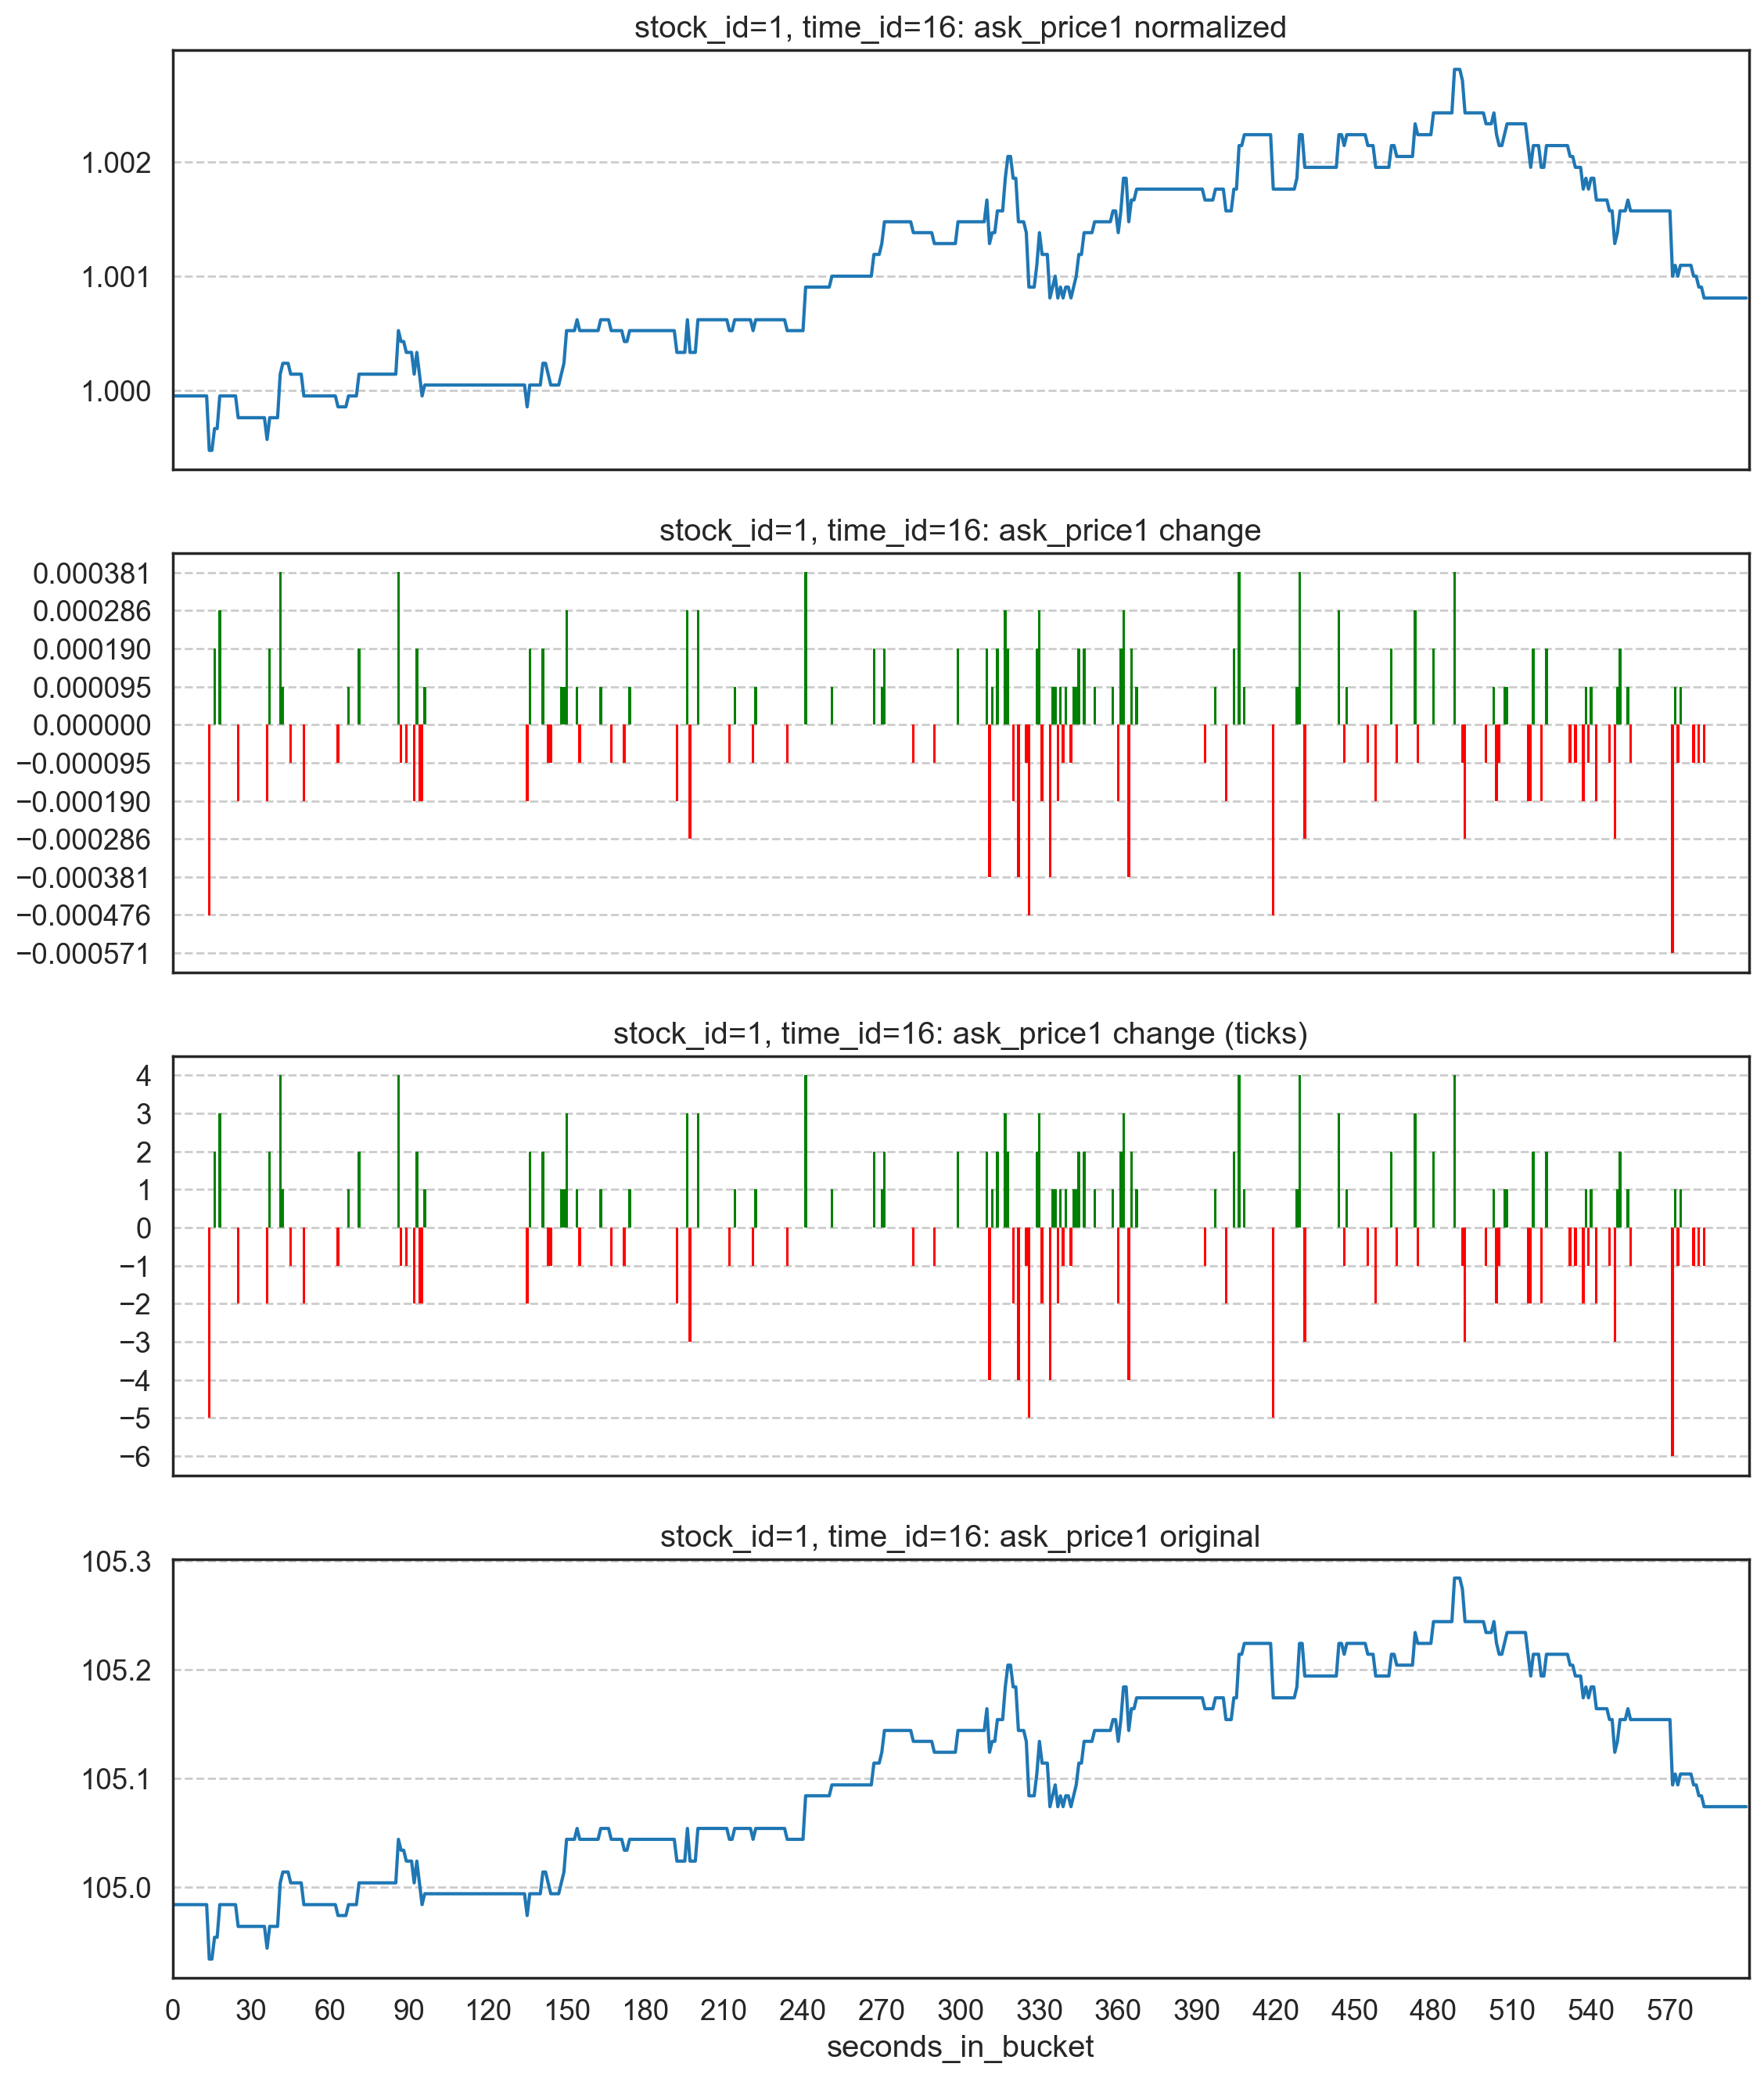

In [6]:
f, ax = plt.subplots(4, 1, sharex=True, figsize=(13, 16))        
plot_price(1, 16, 'ask_price1', 'price_norm', ax[0])
plot_price(1, 16, 'ask_price1', 'price_change', ax[1])
plot_price(1, 16, 'ask_price1', 'ticks_change', ax[2])
plot_price(1, 16, 'ask_price1', 'price_original', ax[3])

Now let's recover original prices for each stock_id/time_id and explore them.

In [7]:
def calc_price(df):
    diff = abs(df.diff())
    min_diff = np.nanmin(diff.where(lambda x: x > 0))
    n_ticks = (diff / min_diff).round()
    return 0.01 / np.nanmean(diff / n_ticks)

def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.groupby('time_id').apply(calc_price).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df

In [8]:
df_prices_denorm = pd.concat(Parallel(n_jobs=-1, verbose=0)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))

/var/folders/4q/3p2yjtxj5xvgw2c4slb2vvxw0000gn/T/ipykernel_6654/54321953.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/4q/3p2yjtxj5xvgw2c4slb2vvxw0000gn/T/ipykernel_6654/54321953.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/4q/3p2yjtxj5xvgw2c4slb2vvxw0000gn/T/ipykernel_6654/54321953.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This beh

Here are recovered prices:

In [9]:
df_prices_denorm = df_prices_denorm.pivot(index='time_id', columns='stock_id', values='price')
df_prices_denorm

stock_id         0           1           2           3           4    \
time_id                                                                
5         193.382492  152.416321  123.461426  226.012222  619.198914   
11        199.230484  149.512009  128.641220  249.893173  614.775574   
16        208.900101  104.885666  118.687622  164.755249  534.006470   
31        216.138260  137.831207  138.326843  235.951401  657.637024   
62        214.516327  140.650238  137.213394  238.242508  639.647217   
...              ...         ...         ...         ...         ...   
32751     192.207764  148.865372  132.110580  243.722214  652.082458   
32753     199.748993  143.562744  128.829956  245.019730  616.837402   
32758     198.471329  111.979019  142.683929  216.825653  591.479675   
32763     208.002502   81.295082  116.000504  107.229172  516.903931   
32767     208.721069  101.052147  128.278259  199.130188  564.778259   

stock_id         5           6           7           8           9    ...  \
time_id                                                               ...   
5         738.256592  370.275787  245.870972  283.881409  238.394791  ...   
11        769.481140  411.690094  256.711212  278.116791  244.391083  ...   
16        584.016541  236.595123  208.127701  123.656639  177.405899  ...   
31        804.561646  358.949341  260.607147  194.206650  232.626587  ...   
62        765.430359  403.068359  250.621872  187.756607  243.459991  ...   
...              ...         ...         ...         ...         ...  ...   
32751     745.338501  389.702423  252.020432  252.114136  230.046722  ...   
32753     755.527649  389.036255  249.891006  258.463165  241.465759  ...   
32758     729.433289  509.977234  234.174942  132.590469  206.086533  ...   
32763     502.602844  143.001740  182.616348   94.160759  162.246735  ...   
32767     683.743835  254.351334  245.839813  116.209633  185.205078  ...   

stock_id        115         116         118        119         120  \
time_id                                                              
5         88.143524  246.326035  210.790482  66.225349   96.217049   
11        90.285606  275.919983  213.987640  63.064598  101.239487   
16        70.035149  189.724258  281.007935  53.520546   74.554428   
31        90.688217  256.869873  235.129517  61.245171   90.928452   
62        89.140907  248.061737  231.193771  59.542957   87.940269   
...             ...         ...         ...        ...         ...   
32751     88.523949  269.021423  241.987518  60.049755   93.429985   
32753     91.186058  269.457855  212.935867  62.066113   92.794334   
32758     80.310356  225.500214  211.873459  43.955593   80.582207   
32763     59.235748  151.293915  263.571503  44.825188   66.755135   
32767     76.478989  196.456833  280.672333  51.486736   81.482506   

stock_id         122         123        124        125         126  
time_id                                                             
5         142.352631  108.310135  84.344765  53.375172  310.446014  
11        136.924683  105.482063  91.095215  55.886795  300.948120  
16         93.370636   77.421021  55.054432  53.084003  194.495605  
31        134.847290  103.739265  92.465027  58.124481  259.149048  
62        125.482864  103.529648  96.060417  57.373158  259.214203  
...              ...         ...        ...        ...         ...  
32751     135.630814  103.531319  94.184822  56.814400  306.255493  
32753     136.533142  104.054977  87.874306  55.995628  290.136261  
32758     111.225449   89.826469  81.064095  56.597614  202.570511  
32763      77.321220   71.994965  52.124935  50.174789  151.879456  
32767     105.091736   75.074348  68.755608  55.856964  194.435959  

[3830 rows x 112 columns]

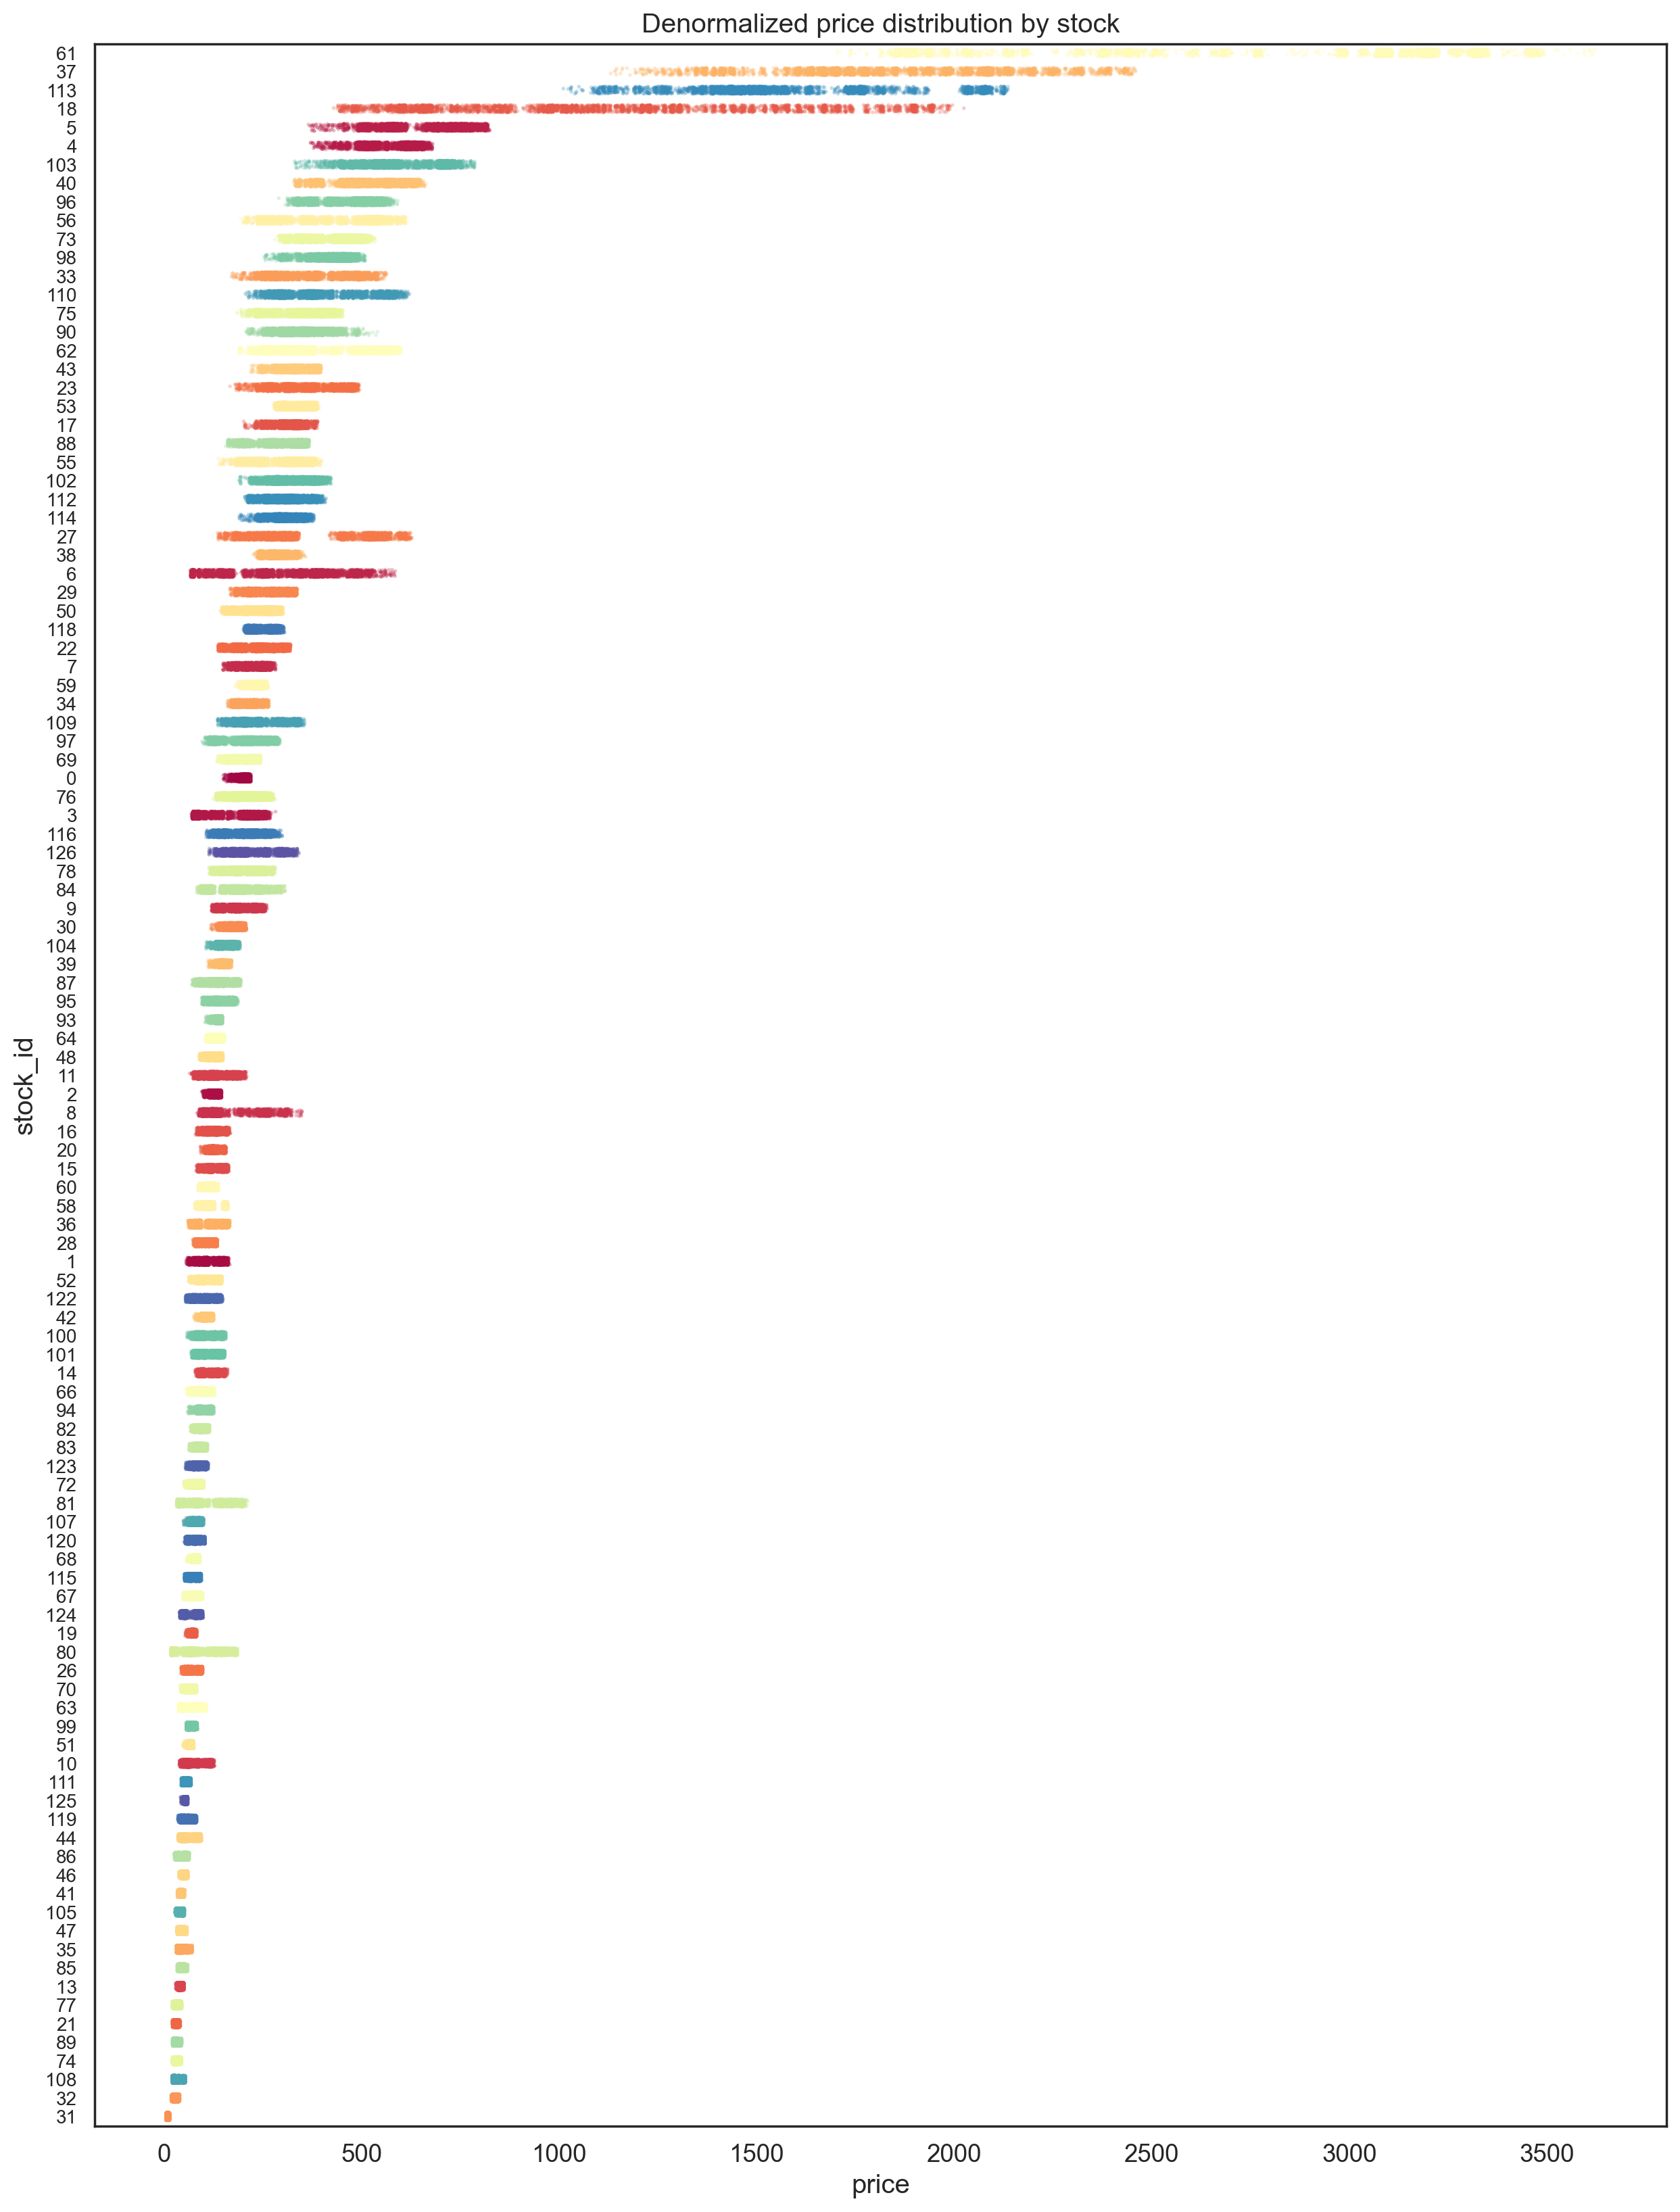

In [10]:
plt.figure(figsize=(15, 20))
ax = sns.stripplot(data=df_prices_denorm, orient='h', alpha=0.3, s=2, jitter=0.2,
                   order=df_prices_denorm.median().sort_values().index[::-1].tolist(), 
                   palette='Spectral')
ax.tick_params(axis='y', which='major', labelsize=10)
plt.xlabel('price')
plt.title('Denormalized price distribution by stock');

*Note: this idea is based on assumption that tick size is constant for all time_id/stock_id and is equal to \\$0.01, otherwise the resulting prices might be different.*

Let's also download some real stock prices for comparison from approximately the same period as training data

## Not working - some problems with YFinance

In [11]:
import yfinance as yf

In [12]:
SP100_tickers = pd.read_html('https://en.wikipedia.org/wiki/S%26P_100')[2].Symbol
df_prices_real = yf.download(SP100_tickers.to_list(), start='2020-01-01', end='2021-06-01', interval='1h')
#df_prices_real = pd.read_hdf('/kaggle/input/orvp-dataset/prices_real.hdf', key='prices')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  101 of 101 completed

101 Failed downloads:
['IBM', 'COP', 'MCD', 'CMCSA', 'COF', 'MRK', 'JNJ', 'DUK', 'GOOGL', 'JPM', 'NVDA', 'AMT', 'UNH', 'BAC', 'RTX', 'LIN', 'INTC', 'GM', 'CL', 'XOM', 'EMR', 'PYPL', 'ISRG', 'GD', 'TSLA', 'MSFT', 'LMT', 'LOW', 'SBUX', 'BK', 'NOW', 'NKE', 'BKNG', 'META', 'DE', 'SO', 'COST', 'WMT', 'CVS', 'GOOG', 'MO', 'MA', 'CVX', 'SCHW', 'MDT', 'INTU', 'QCOM', 'HON', 'MDLZ', 'PG', 'ABT', 'PM', 'BMY', 'USB', 'ORCL', 'TMUS', 'CHTR', 'CSCO', 'AXP', 'AVGO', 'BA', 'VZ', 'AAPL', 'NFLX', 'CAT', 'DHR', 'SPG', 'TMO', 'AIG', 'GE', 'NEE', 'AMD', 'GS', 'GILD', 'C', 'ADBE', 'WFC', 'PFE', 'PEP', 'CRM', 'LLY', 'MET', 'AMZN', 'HD', 'KO', 'V', 'AMGN', 'ABBV', 'UPS', 'TGT', 'UNP', 'T', 'MMM', 'ACN', 'MS', 'DIS', 'FDX', 'TXN', 'BLK']: YFPricesMissingError('possibly delisted; no price data found  (1h 2020-01-01 -> 2021-06-01) (Yahoo error = "1h data not available for startTime=1577854800 and endTime=1622520000. The requested range mu

In [13]:
df_prices_real.head()

Empty DataFrame
Columns: [(Adj Close, AAPL), (Adj Close, ABBV), (Adj Close, ABT), (Adj Close, ACN), (Adj Close, ADBE), (Adj Close, AIG), (Adj Close, AMD), (Adj Close, AMGN), (Adj Close, AMT), (Adj Close, AMZN), (Adj Close, AVGO), (Adj Close, AXP), (Adj Close, BA), (Adj Close, BAC), (Adj Close, BK), (Adj Close, BKNG), (Adj Close, BLK), (Adj Close, BMY), (Adj Close, BRK.B), (Adj Close, C), (Adj Close, CAT), (Adj Close, CHTR), (Adj Close, CL), (Adj Close, CMCSA), (Adj Close, COF), (Adj Close, COP), (Adj Close, COST), (Adj Close, CRM), (Adj Close, CSCO), (Adj Close, CVS), (Adj Close, CVX), (Adj Close, DE), (Adj Close, DHR), (Adj Close, DIS), (Adj Close, DUK), (Adj Close, EMR), (Adj Close, FDX), (Adj Close, GD), (Adj Close, GE), (Adj Close, GILD), (Adj Close, GM), (Adj Close, GOOG), (Adj Close, GOOGL), (Adj Close, GS), (Adj Close, HD), (Adj Close, HON), (Adj Close, IBM), (Adj Close, INTC), (Adj Close, INTU), (Adj Close, ISRG), (Adj Close, JNJ), (Adj Close, JPM), (Adj Close, KO), (Adj Close, LIN), (Adj Close, LLY), (Adj Close, LMT), (Adj Close, LOW), (Adj Close, MA), (Adj Close, MCD), (Adj Close, MDLZ), (Adj Close, MDT), (Adj Close, MET), (Adj Close, META), (Adj Close, MMM), (Adj Close, MO), (Adj Close, MRK), (Adj Close, MS), (Adj Close, MSFT), (Adj Close, NEE), (Adj Close, NFLX), (Adj Close, NKE), (Adj Close, NOW), (Adj Close, NVDA), (Adj Close, ORCL), (Adj Close, PEP), (Adj Close, PFE), (Adj Close, PG), (Adj Close, PLTR), (Adj Close, PM), (Adj Close, PYPL), (Adj Close, QCOM), (Adj Close, RTX), (Adj Close, SBUX), (Adj Close, SCHW), (Adj Close, SO), (Adj Close, SPG), (Adj Close, T), (Adj Close, TGT), (Adj Close, TMO), (Adj Close, TMUS), (Adj Close, TSLA), (Adj Close, TXN), (Adj Close, UNH), (Adj Close, UNP), (Adj Close, UPS), (Adj Close, USB), (Adj Close, V), (Adj Close, VZ), (Adj Close, WFC), (Adj Close, WMT), ...]
Index: []

[0 rows x 606 columns]

Calculating real prices volatility from OLHC data using GARMAN-KLASS estimator (thanks @lucasmorin)

In [14]:
df_volatility_real = 1 / 2 * np.log(df_prices_real.High / df_prices_real.Low) ** 2 - \
    (2 * np.log(2) - 1) * np.log(df_prices_real.Close / df_prices_real.Open) ** 2
df_volatility_real = df_volatility_real.mean(axis=1)

df_prices_real = df_prices_real.Open.fillna(df_prices_real.Open.mean()).dropna(axis=1).sample(frac=1)
df_volatility_real = df_volatility_real.loc[df_prices_real.index]
df_prices_real

Empty DataFrame
Columns: [AAPL, ABBV, ABT, ACN, ADBE, AIG, AMD, AMGN, AMT, AMZN, AVGO, AXP, BA, BAC, BK, BKNG, BLK, BMY, BRK.B, C, CAT, CHTR, CL, CMCSA, COF, COP, COST, CRM, CSCO, CVS, CVX, DE, DHR, DIS, DUK, EMR, FDX, GD, GE, GILD, GM, GOOG, GOOGL, GS, HD, HON, IBM, INTC, INTU, ISRG, JNJ, JPM, KO, LIN, LLY, LMT, LOW, MA, MCD, MDLZ, MDT, MET, META, MMM, MO, MRK, MS, MSFT, NEE, NFLX, NKE, NOW, NVDA, ORCL, PEP, PFE, PG, PLTR, PM, PYPL, QCOM, RTX, SBUX, SCHW, SO, SPG, T, TGT, TMO, TMUS, TSLA, TXN, UNH, UNP, UPS, USB, V, VZ, WFC, WMT, ...]
Index: []

[0 rows x 101 columns]

In [15]:
df_prices_denorm_scaled = df_prices_denorm.fillna(df_prices_denorm.mean())
df_prices_denorm_scaled = pd.DataFrame(minmax_scale(df_prices_denorm_scaled), index=df_prices_denorm.index)

#df_prices_real_scaled = df_prices_real.fillna(df_prices_real.mean())
#df_prices_real_scaled = pd.DataFrame(minmax_scale(df_prices_real_scaled), index=df_prices_real.index)

In [16]:
df_prices_denorm_scaled

0         1         2         3         4         5         6    \
time_id                                                                         
5        0.618272  0.870656  0.552631  0.735930  0.804299  0.812166  0.585260   
11       0.701341  0.844599  0.654116  0.848059  0.789978  0.880214  0.665091   
16       0.838694  0.444232  0.459101  0.448309  0.528474  0.476028  0.327572   
31       0.941509  0.739805  0.843880  0.782598  0.928749  0.956666  0.563426   
62       0.918470  0.765096  0.822065  0.793355  0.870504  0.871386  0.648472   
...           ...       ...       ...       ...       ...       ...       ...   
32751    0.601585  0.838798  0.722089  0.819084  0.910765  0.827600  0.622707   
32753    0.708706  0.791225  0.657814  0.825176  0.796653  0.849805  0.621423   
32758    0.690557  0.507870  0.929246  0.692796  0.714553  0.792937  0.854553   
32763    0.825944  0.232588  0.406454  0.178205  0.473102  0.298602  0.147159   
32767    0.836151  0.409839  0.647004  0.609710  0.628103  0.693366  0.361800   

              7         8         9    ...       102       103       104  \
time_id                                ...                                 
5        0.724101  0.753313  0.838174  ...  0.847039  0.725234  0.099812   
11       0.804527  0.731652  0.880553  ...  0.896366  0.878752  0.130230   
16       0.444076  0.151266  0.407136  ...  0.430045  0.431614  0.767861   
31       0.833431  0.416359  0.797407  ...  0.905637  0.779930  0.331374   
62       0.759349  0.392123  0.873972  ...  0.870006  0.734238  0.293929   
...           ...       ...       ...  ...       ...       ...       ...   
32751    0.769725  0.633947  0.779174  ...  0.855799  0.842966  0.396621   
32753    0.753926  0.657803  0.859878  ...  0.917101  0.845230  0.120224   
32758    0.637326  0.184835  0.609836  ...  0.666659  0.617201  0.110116   
32763    0.254802  0.040435  0.299999  ...  0.181360  0.232258  0.601971   
32767    0.723870  0.123284  0.462257  ...  0.578432  0.466539  0.764668   

              105       106       107       108       109       110       111  
time_id                                                                        
5        0.650358  0.848136  0.928711  0.934403  0.757303  0.636125  0.863727  
11       0.584336  0.942446  0.871643  0.885871  0.869485  0.772331  0.822066  
16       0.384980  0.441361  0.413728  0.404318  0.270542  0.620335  0.355131  
31       0.546332  0.748828  0.849802  0.855963  0.892249  0.893681  0.638722  
62       0.510776  0.692717  0.751347  0.852366  0.951999  0.852937  0.639007  
...           ...       ...       ...       ...       ...       ...       ...  
32751    0.521362  0.795802  0.858040  0.852394  0.920829  0.822635  0.845346  
32753    0.563480  0.783865  0.867527  0.861381  0.815958  0.778233  0.774642  
32758    0.185187  0.554549  0.601448  0.617207  0.702783  0.810879  0.390550  
32763    0.203351  0.294908  0.244988  0.311202  0.221858  0.462569  0.168202  
32767    0.342498  0.571455  0.536960  0.364047  0.498235  0.770713  0.354869  

[3830 rows x 112 columns]

### Can we recover time_id order from denormalized prices?

*I found this task an intersting exercise alongside with the main competition goal, I worked on it when I was stuck with other normal ideas.*

We can treat each time_id row as a point in a 112 dimensional space, where temporally close time_ids should be close in that space. Ideally, there should be a continuous 1d manifold/curve. So lets try different dimensionality reduction methods on both denormalized and real prices for comparison.

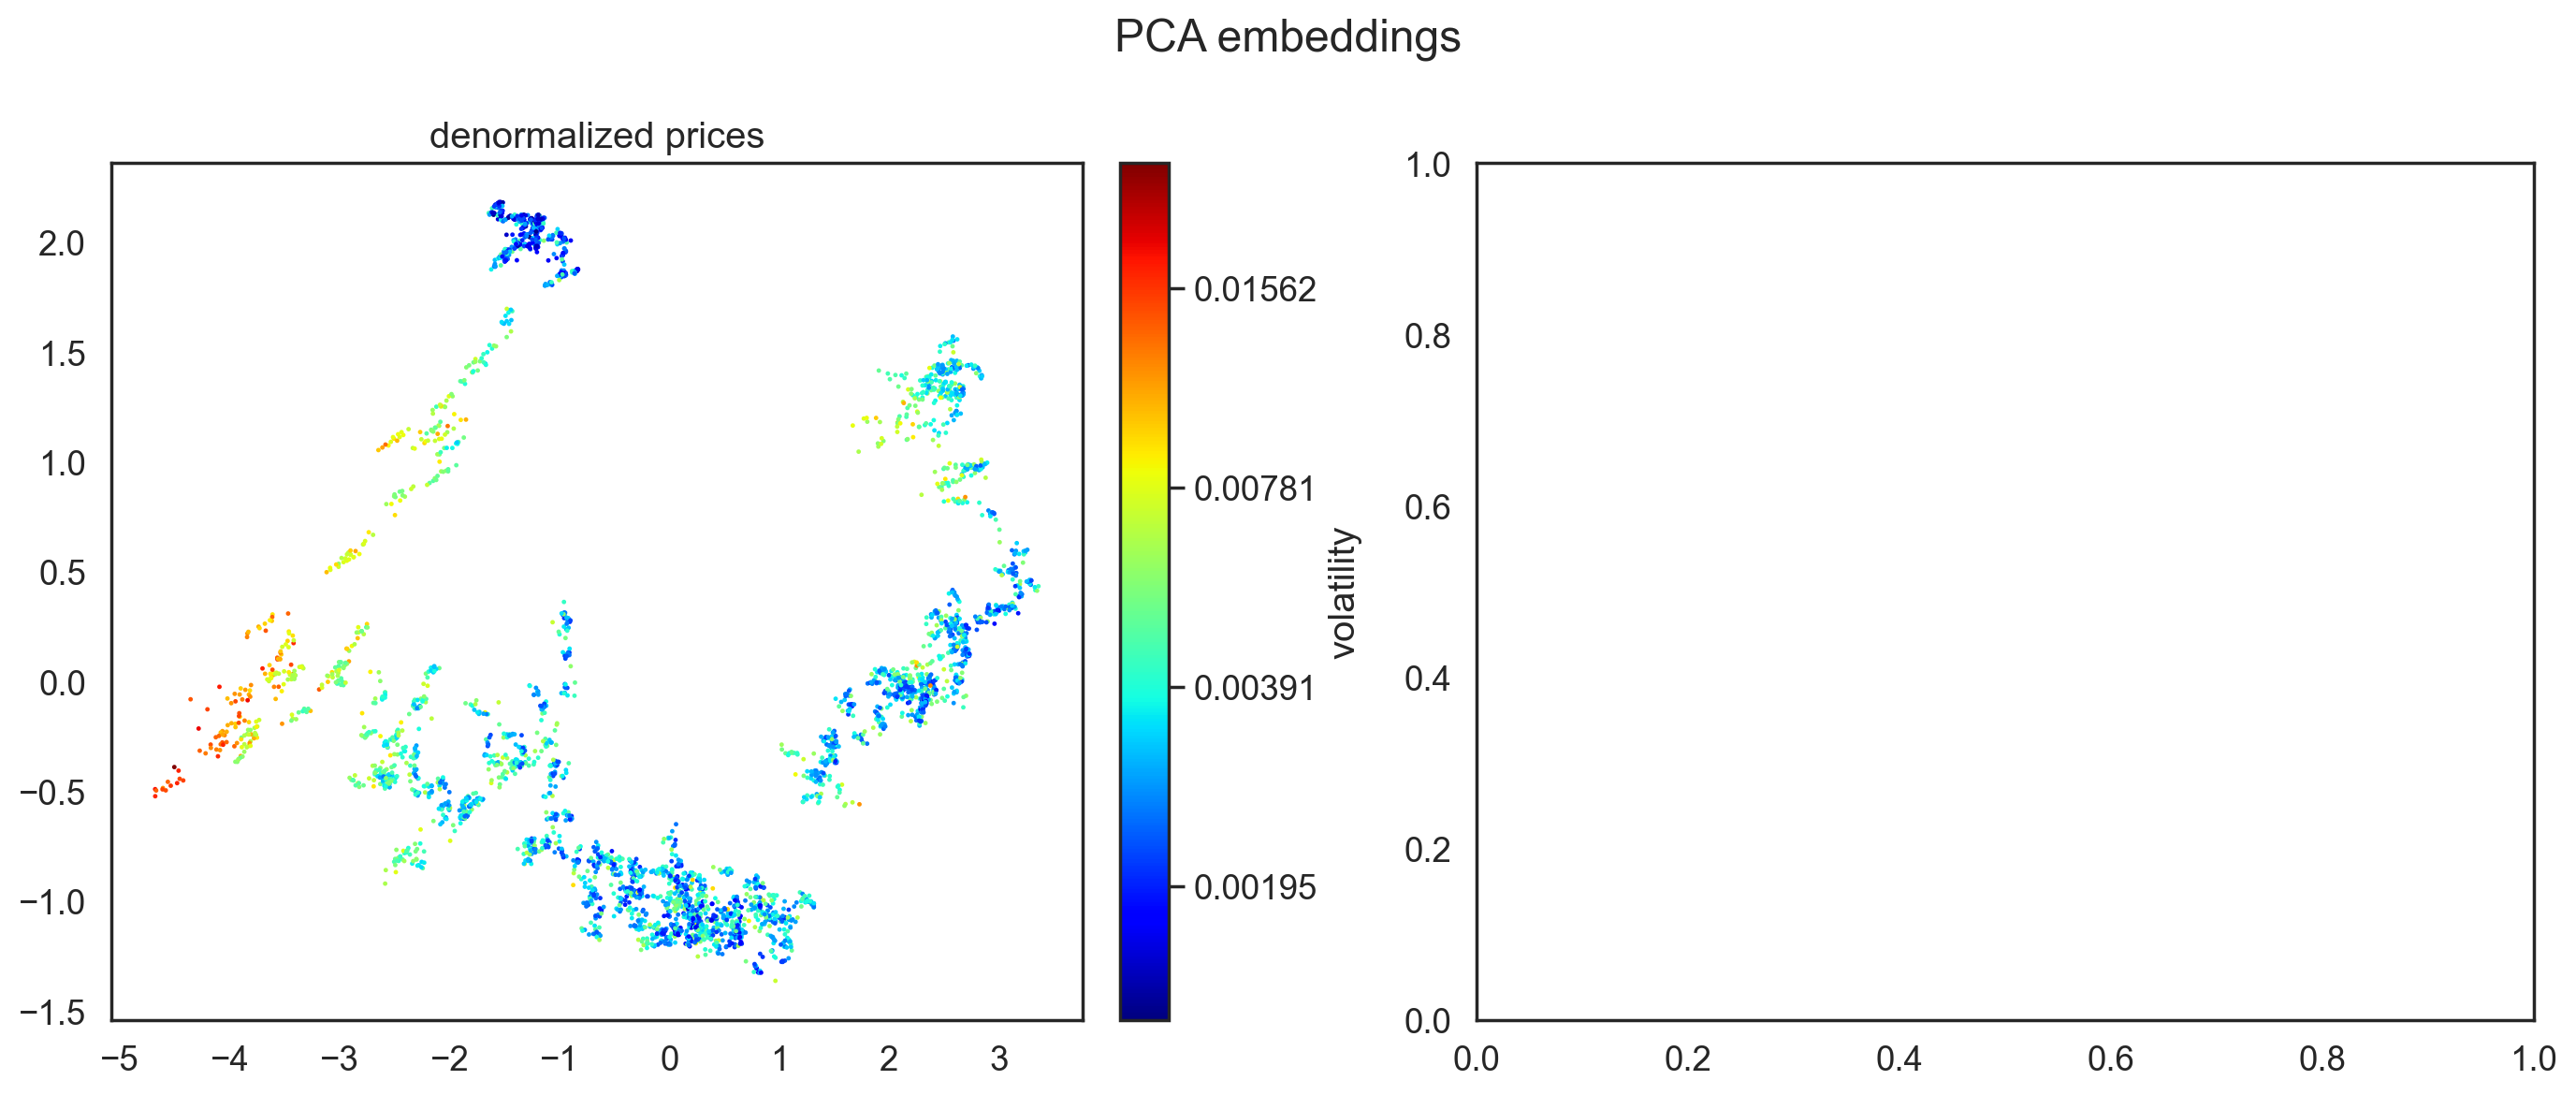

In [21]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))        
emb = PCA(n_components=2)
emb_denorm = emb.fit_transform(df_prices_denorm_scaled)
#emb_real = emb.fit_transform(df_prices_real_scaled)
plot_emb(emb_denorm, df_volatility_train, 'denormalized prices', 'volatility', f, ax[0])
#plot_emb(emb_real, df_volatility_real, 'real prices', 'volatility', f, ax[1])
f.suptitle('PCA embeddings')
plt.tight_layout()

/opt/homebrew/Caskroom/miniforge/base/envs/nnet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3830 samples in 0.002s...
[t-SNE] Computed neighbors for 3830 samples in 0.163s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3830
[t-SNE] Computed conditional probabilities for sample 2000 / 3830
[t-SNE] Computed conditional probabilities for sample 3000 / 3830
[t-SNE] Computed conditional probabilities for sample 3830 / 3830
[t-SNE] Mean sigma: 0.232494
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.949532
[t-SNE] KL divergence after 2000 iterations: 0.153754


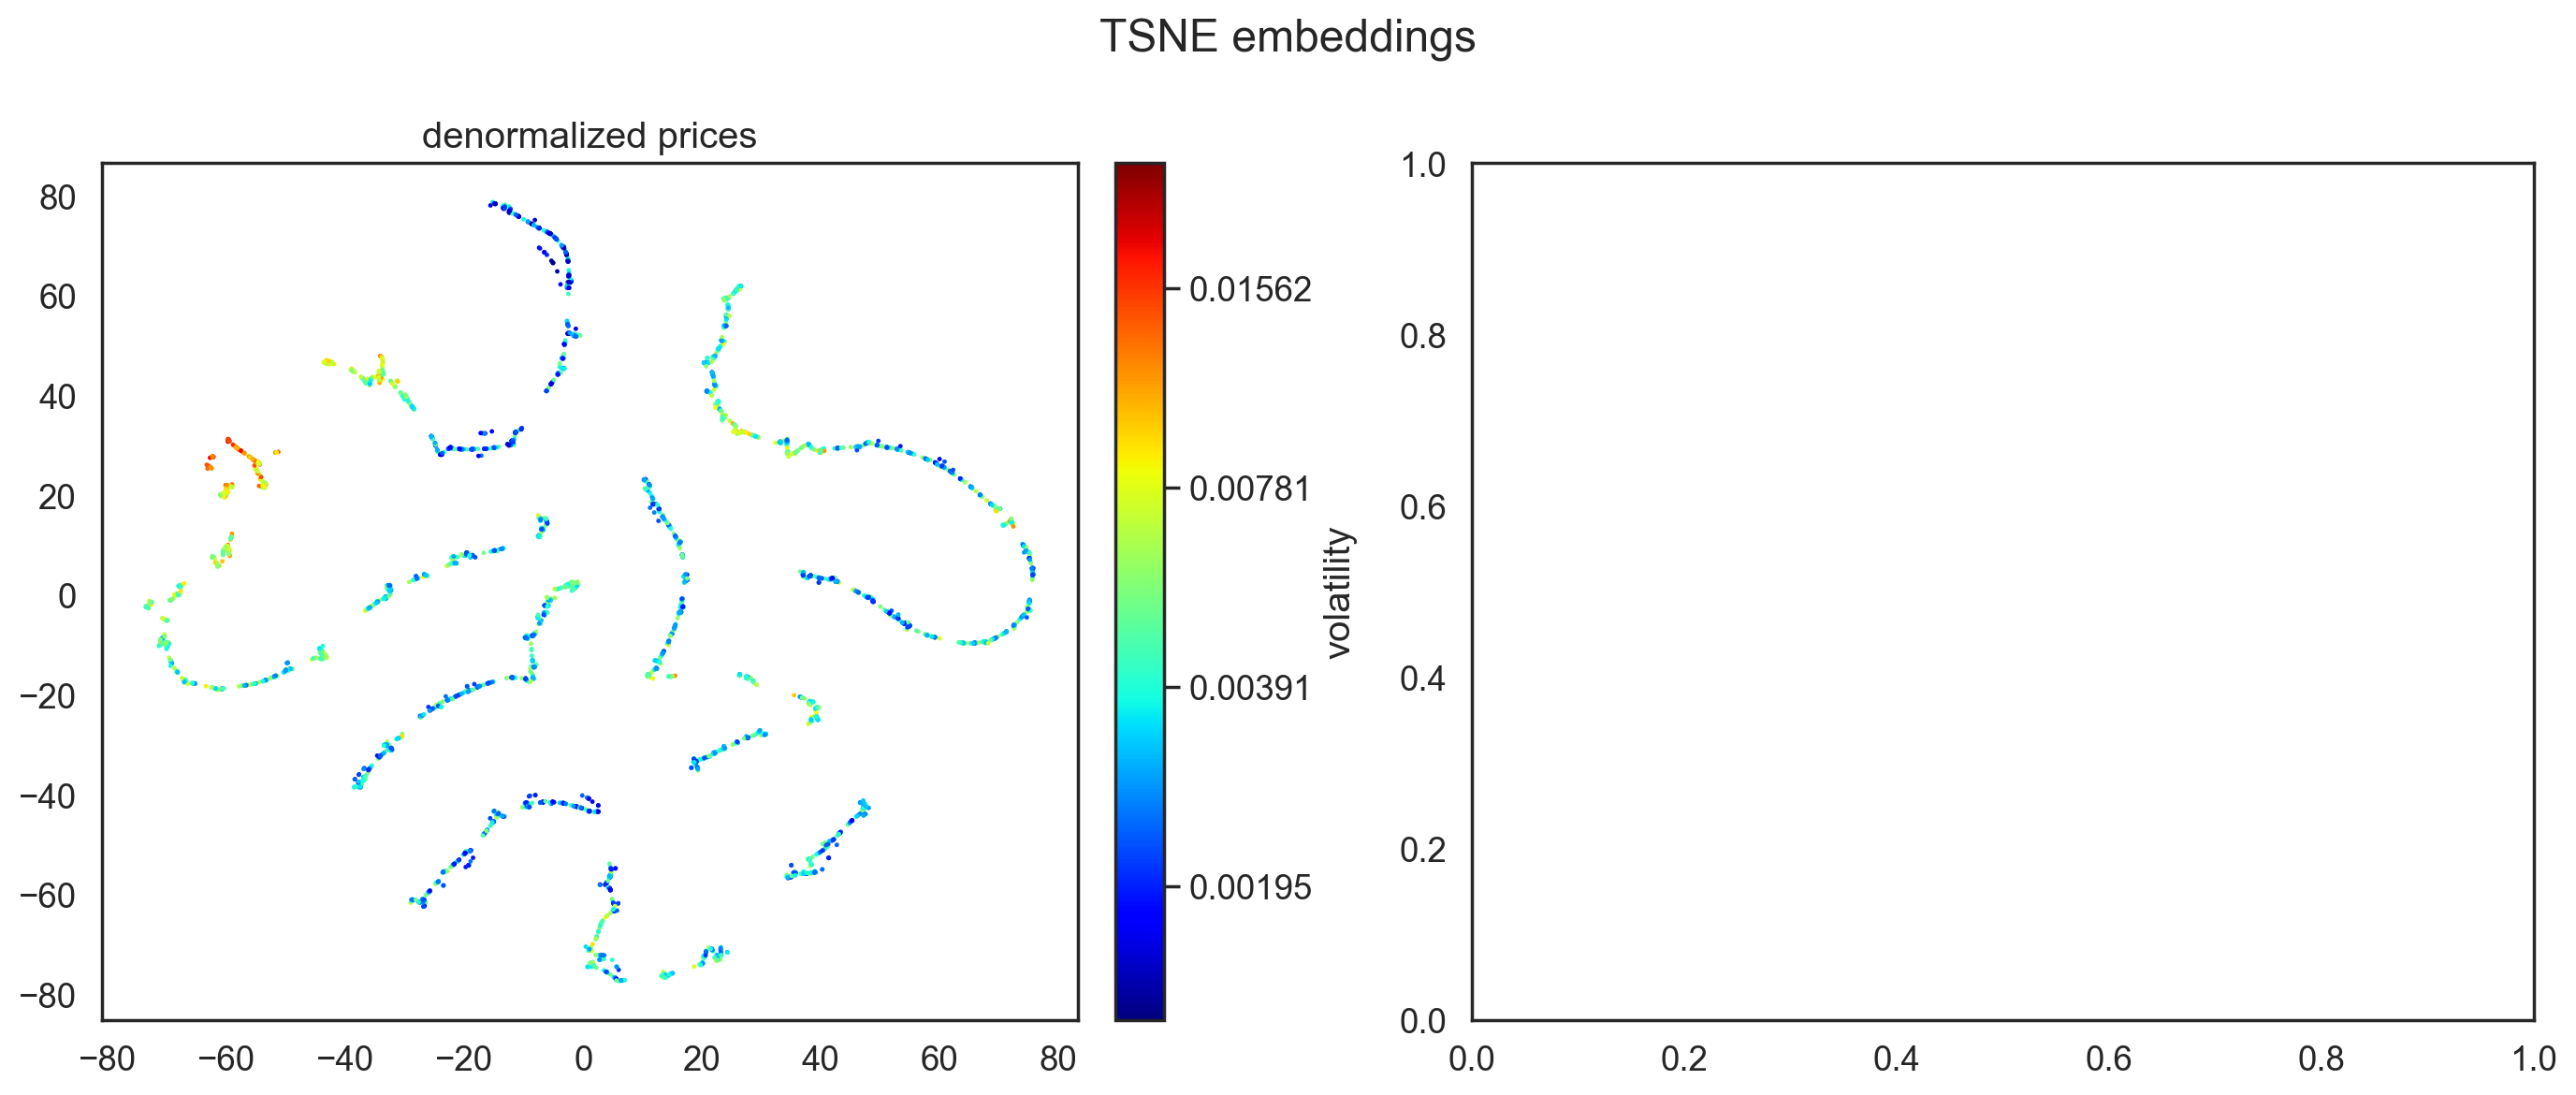

In [24]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))        
emb = TSNE(n_components=2, perplexity=40, learning_rate=50, 
           verbose=1, init='pca', n_iter=2000,
           early_exaggeration=12)
emb_denorm = emb.fit_transform(df_prices_denorm_scaled)
# emb_real = emb.fit_transform(df_prices_real_scaled)
plot_emb(emb_denorm, df_volatility_train, 'denormalized prices', 'volatility', f, ax[0])
# plot_emb(emb_real, df_volatility_real, 'real prices', 'volatility', f, ax[1])
f.suptitle('TSNE embeddings')
plt.tight_layout()

In [30]:
import umap

AttributeError: module 'umap' has no attribute 'UMAP'

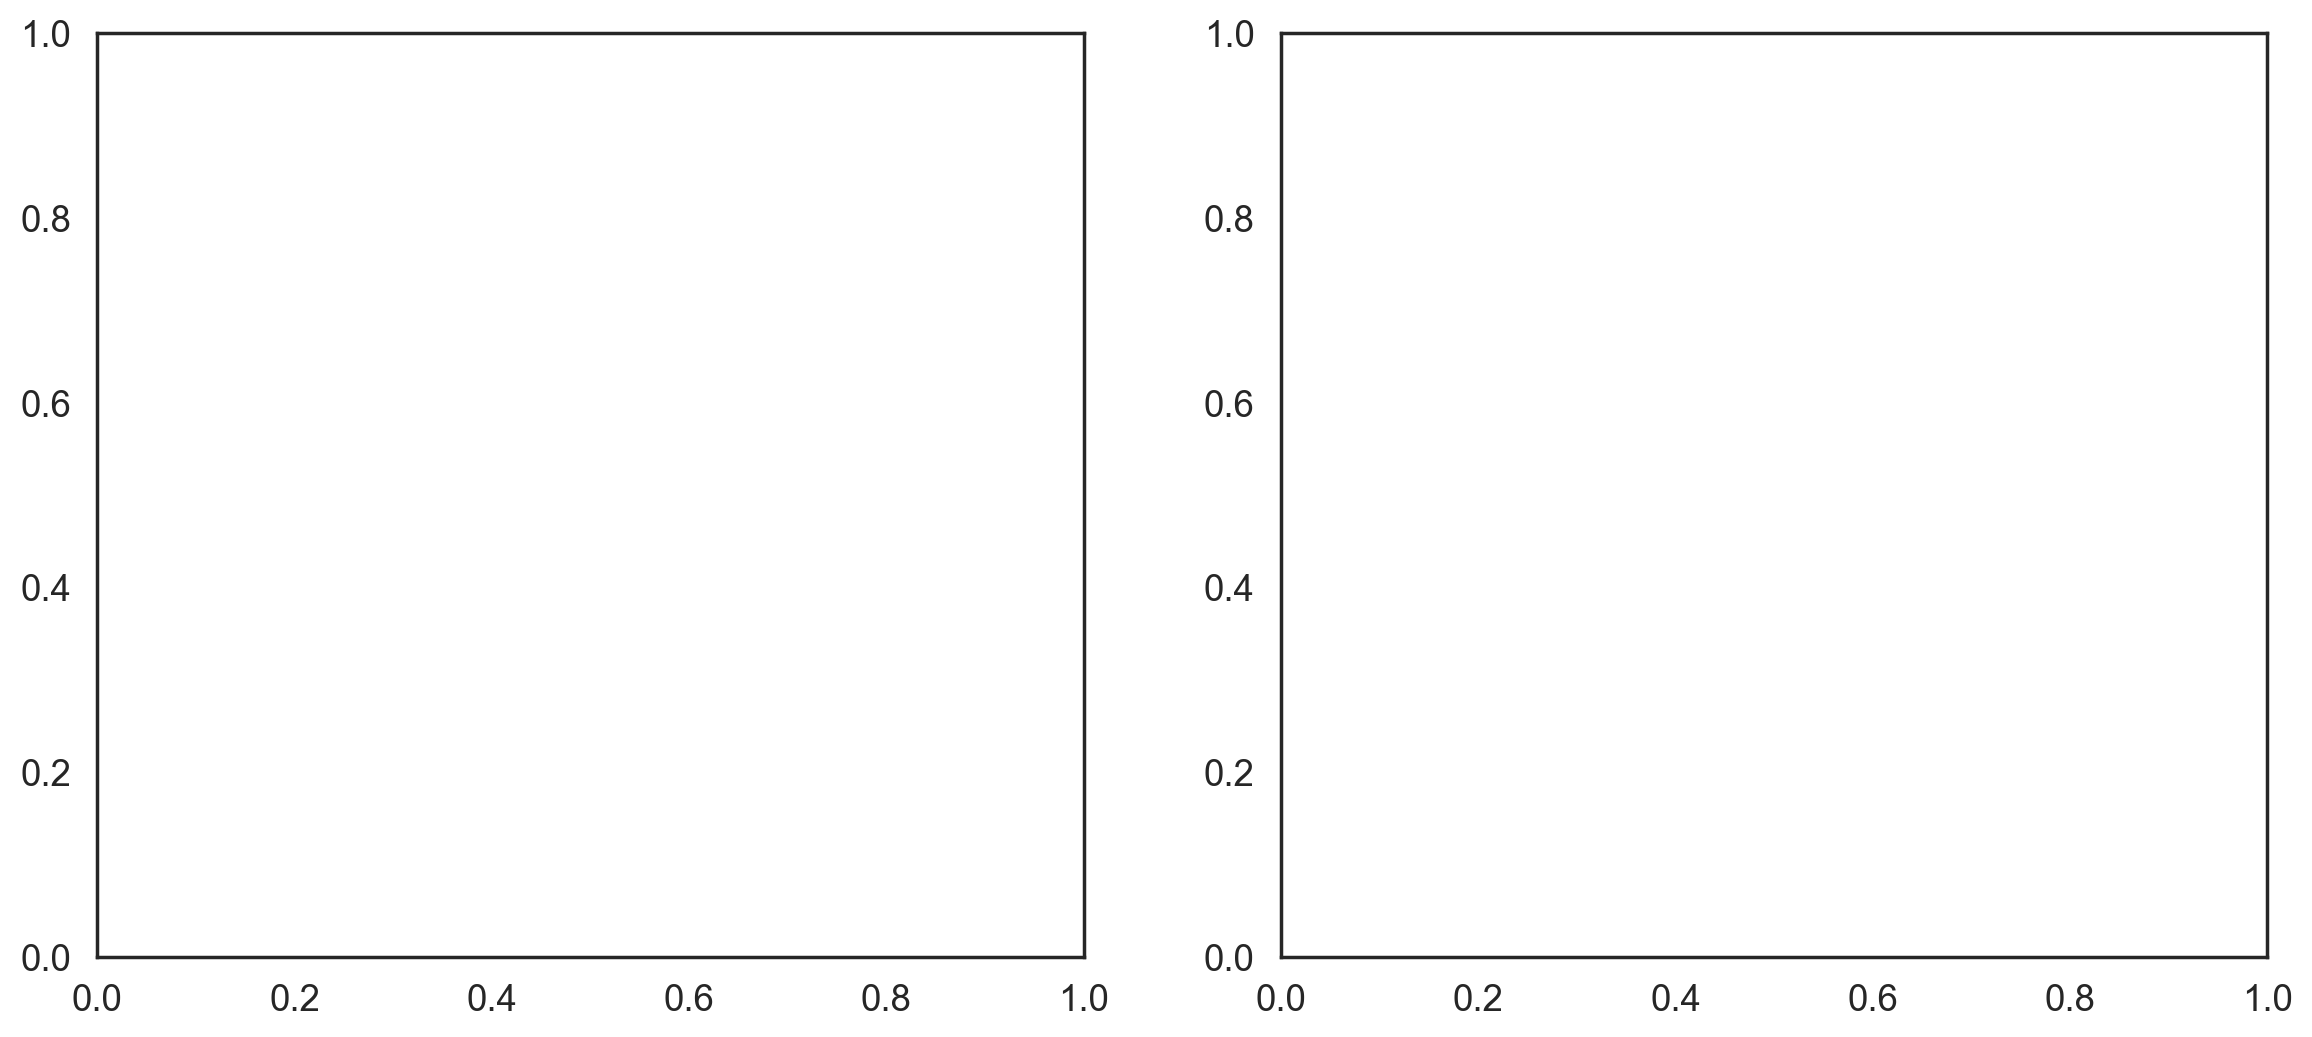

In [31]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))        
emb = umap.UMAP(n_neighbors=60, min_dist=0.1, target_metric='euclidean', 
                init='spectral',  low_memory=False, verbose=True, 
                spread=0.5, local_connectivity=1, repulsion_strength=1, 
                negative_sample_rate=5)
emb_denorm = emb.fit_transform(df_prices_denorm_scaled)
# emb_real = emb.fit_transform(df_prices_real_scaled)
plot_emb(emb_denorm, df_volatility_train, 'denormalized prices', 'volatility', f, ax[0])
# plot_emb(emb_real, df_volatility_real, 'real prices', 'volatility', f, ax[1])
f.suptitle('UMAP embeddings')
plt.tight_layout()

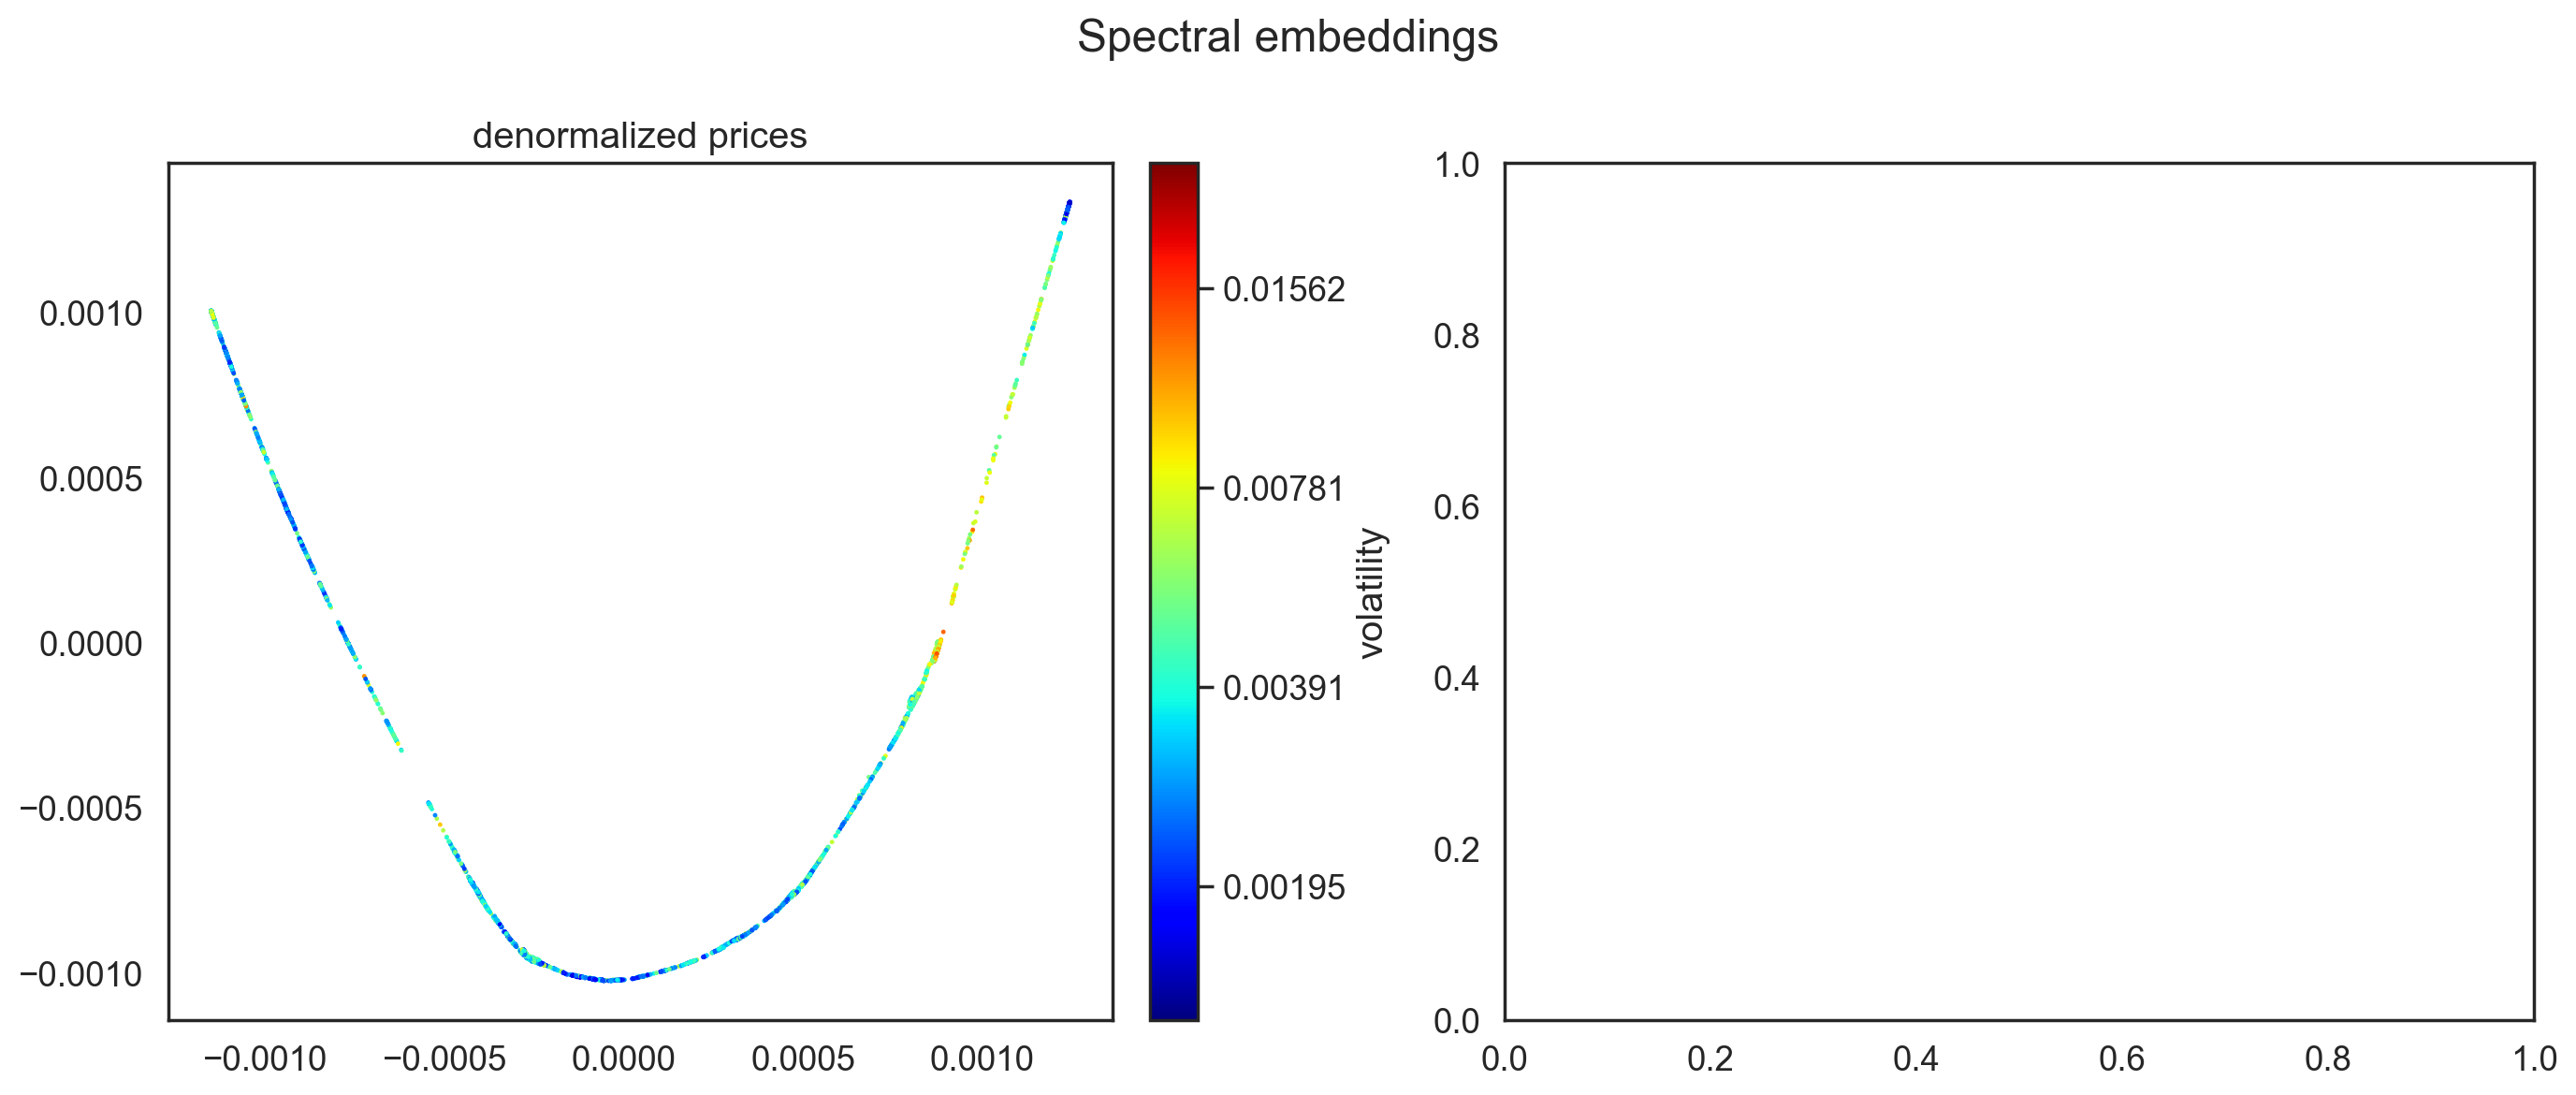

In [32]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))        
emb = SpectralEmbedding(random_state=2)
emb_denorm = emb.fit_transform(df_prices_denorm_scaled)
# emb_real = emb.fit_transform(df_prices_real_scaled)
plot_emb(emb_denorm, df_volatility_train, 'denormalized prices', 'volatility', f, ax[0])
# plot_emb(emb_real, df_volatility_real, 'real prices', 'volatility', f, ax[1])
f.suptitle('Spectral embeddings')
plt.tight_layout()

Well, there a few interesting insights from the plots above:
1. There are definetely a lot of similarities between embeddings of denorm prices vs real prices - both shapes and colors. This can confirm that price denormalization works correctly.
2. We indeed see long continuous segments as it was expected.
3. There is a single outstanding cluster of high volatility, and as we know that real data includes period of [2020 stock market crash](https://en.wikipedia.org/wiki/2020_stock_market_crash) we can pretty confidently assume that this is the same cluster in training data.
4. Spectral embeddings look very nice - there is single connected line and we can easily order all points from left to right.

To confirm our hypothesis that spectral embedding indeed sorts points by date, let's show the same plot but colorcode it by date, as we know it for real prices.

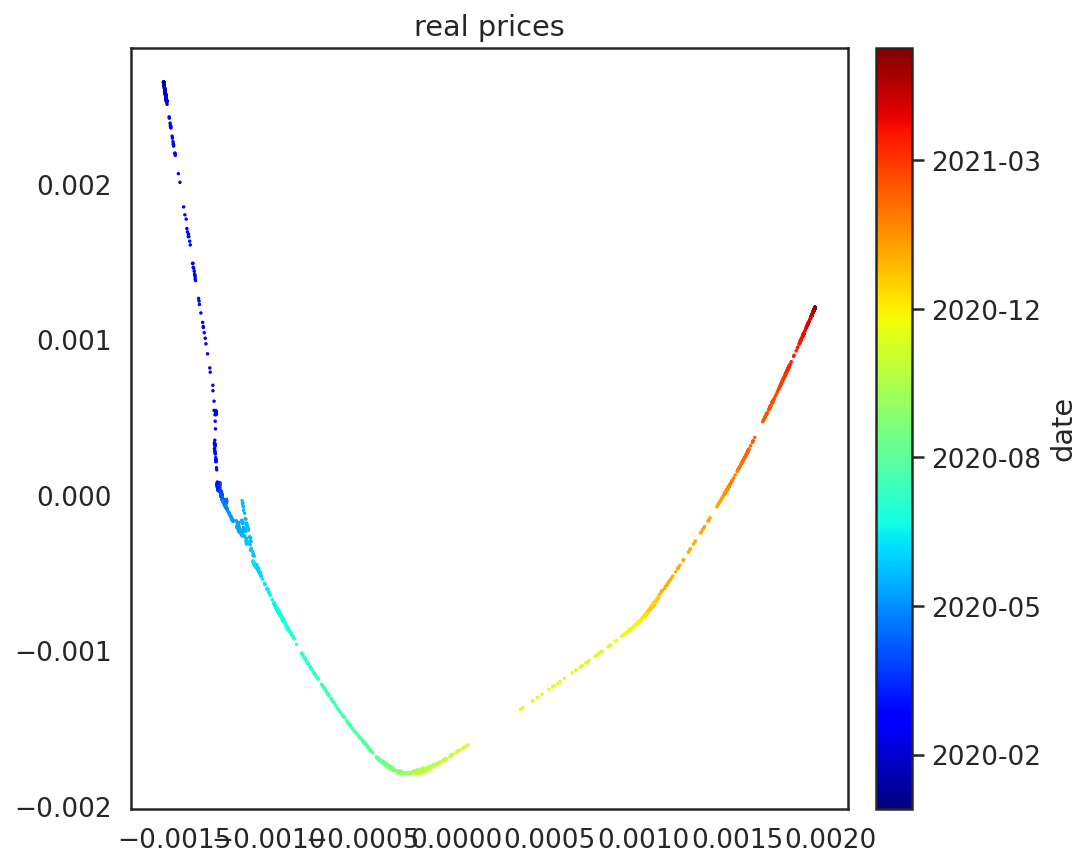

In [17]:
plot_emb(emb_real, [mpl.dates.date2num(i) for i in df_volatility_real.index], 'real prices', 'date')

Cool! We can see, that spectral embedding indeed sorts all points by date. So we now can use X-coordinate of embeddings to approximately recover time order of time_ids in training data.

In [33]:
df_prices_denorm_ordered = df_prices_denorm.iloc[np.argsort(-emb_denorm[:, 0])]

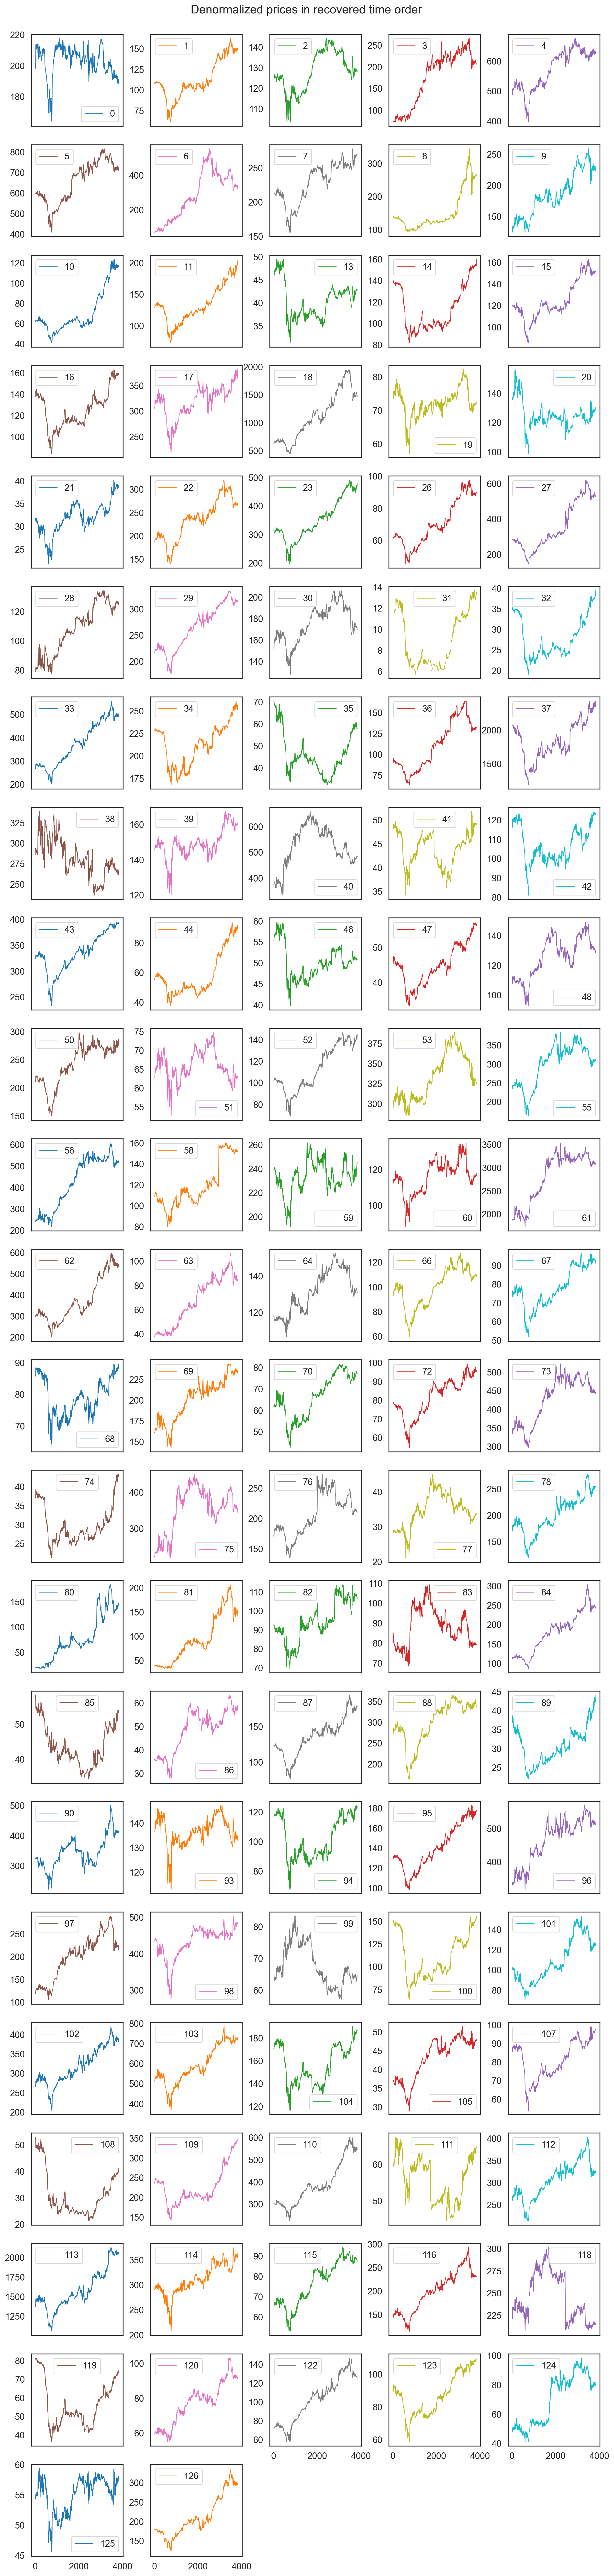

In [ ]:
df_prices_denorm_ordered.reset_index(drop=True).rolling(10).mean(). \
    plot(subplots=True, layout=(-1, 5), figsize=(15, 60), sharex=True, lw=1)
plt.suptitle('Denormalized prices in recovered time order')
plt.subplots_adjust(top=0.97, wspace=0.3)

Looks pretty reasonable - you can easily spot 2020 coronavirus crash with following upwards trend on many plots. 

Let's look at real prices for comparison:

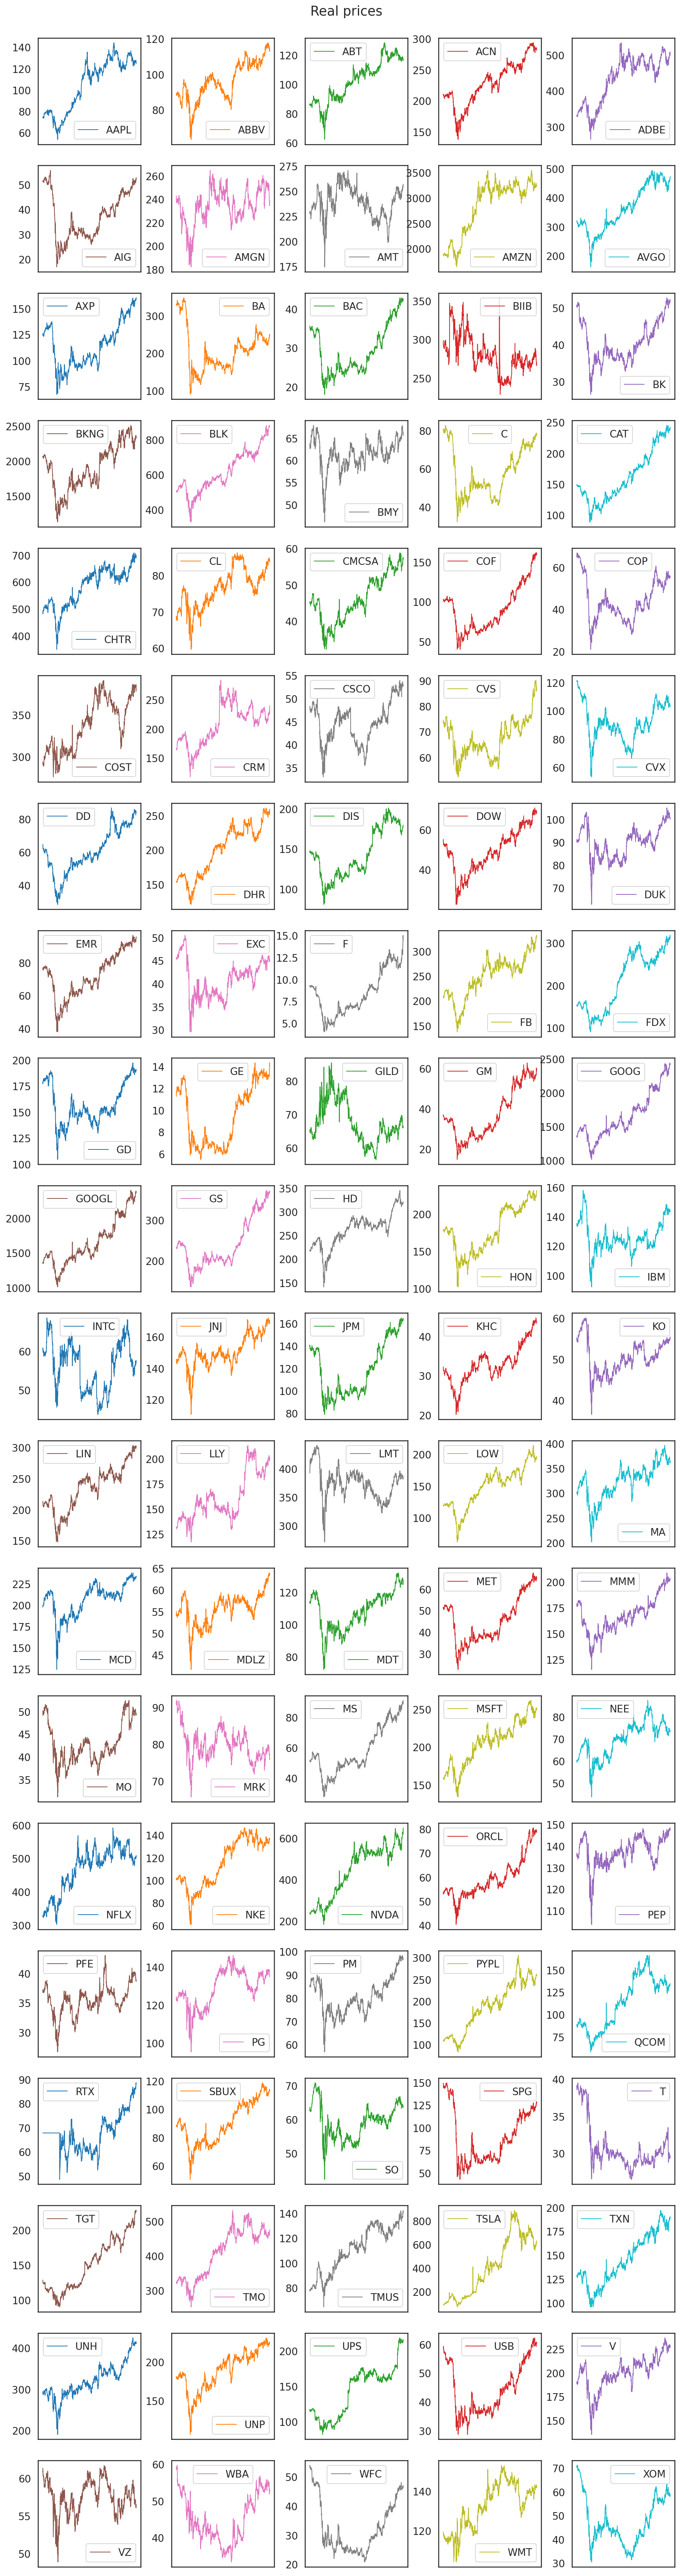

In [20]:
df_prices_real.plot(subplots=True, layout=(-1, 5), figsize=(15, 60), sharex=True, lw=1);
plt.xticks([])
plt.suptitle('Real prices')
plt.subplots_adjust(top=0.97, wspace=0.3);

From denormalized prices distribution plot we can see that the most expensive stock (61) prices are in range 1800-3500, which matches AMZN prices for 2020-2021(half). Let's plot both of them in a single plot.

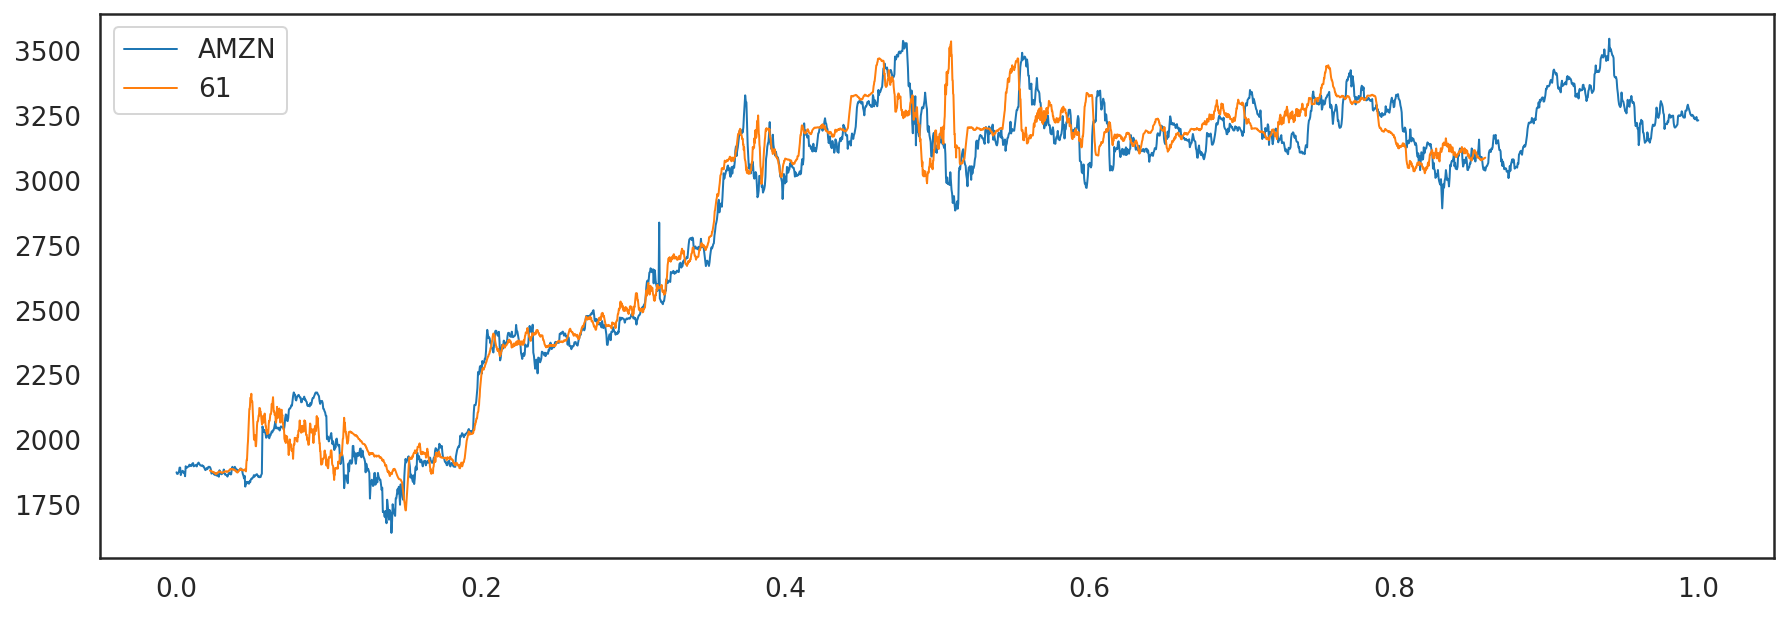

In [21]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
df_prices_real['AMZN'].sort_index().to_frame().set_index(np.linspace(0, 1, len(df_prices_real))).plot(lw=1, ax=ax)
df_prices_denorm_ordered[61].rolling(10).mean().to_frame().set_index(np.linspace(0.02, 0.86, len(df_prices_denorm_ordered))).plot(lw=1, ax=ax);

Another outstanding stock is 31 which has largest RMSPE and lowest price range 6-14. Looking through available real stocks charts we can notice that GE prices look suspiciously similar to it.

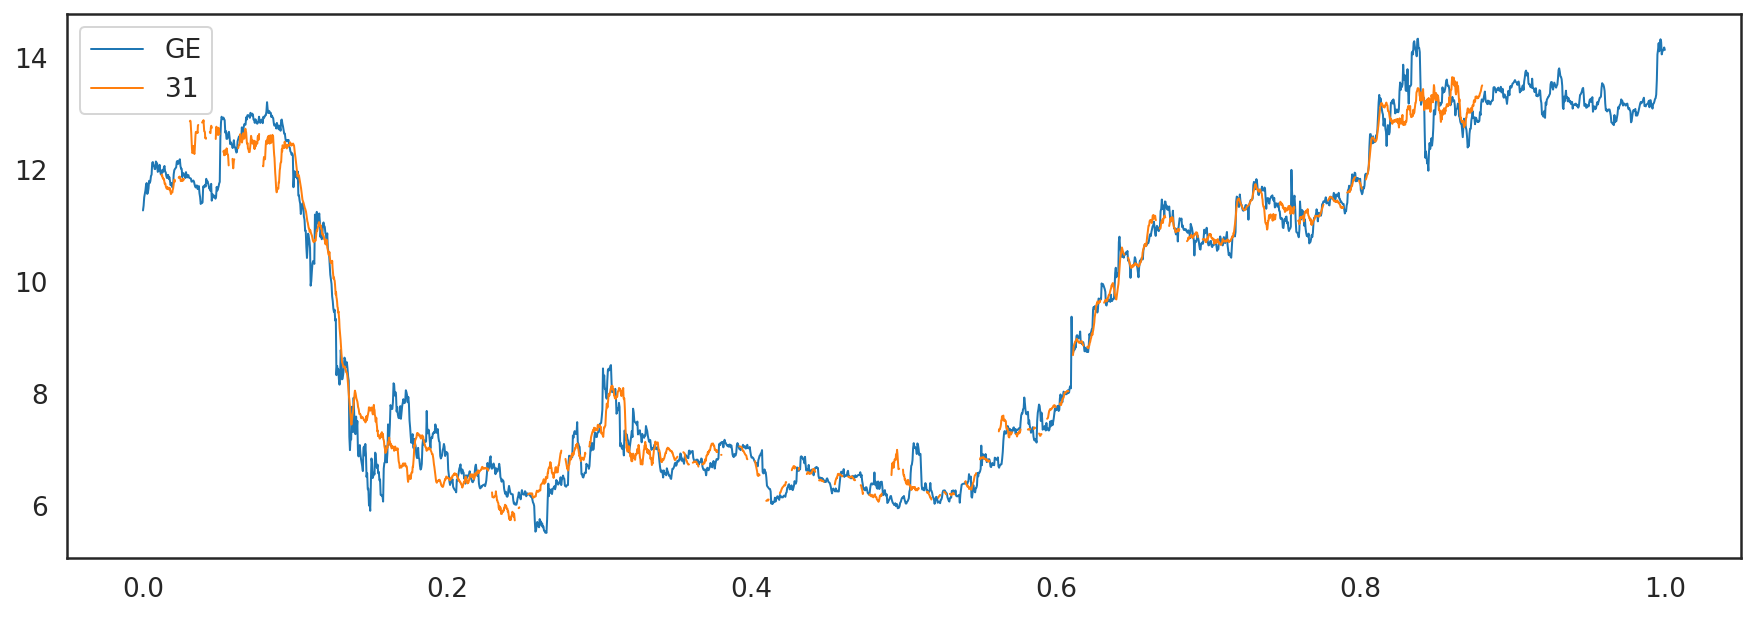

In [22]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
df_prices_real['GE'].sort_index().to_frame().set_index(np.linspace(0, 1, len(df_prices_real))).plot(lw=1, ax=ax)
df_prices_denorm_ordered[31].rolling(10).mean().to_frame().set_index(np.linspace(0, 0.88, len(df_prices_denorm_ordered))).plot(lw=1, ax=ax);

Poor General Electric, it really having a bad time in last years.

<img src="https://user-images.githubusercontent.com/4602302/135102010-fb45f4d9-4d00-4cdd-b571-47dc17f84ac3.png" width="50%"/>
<img src="https://user-images.githubusercontent.com/4602302/135102047-67745529-ef46-4cd2-b784-f79b41504168.png" width="50%"/>

*TODO: Use [Dynamic Time Warping](https://tslearn.readthedocs.io/en/stable/user_guide/dtw.html) to match other stocks.*

### Can we utilize this additional information to improve our model score?

I can't say I found the best way to utilize it with maximum gain, considering that this time ordering method while recovering global order might be quite noisy locally. But one simple idea could be to feed into our model features from nearest time_ids besides current one.

Let's try it with the most basic linear model with one feature: current realized volatility.

In [23]:
def calc_rv(r):
    df = pd.read_parquet(r.book_path)
    df['wap'] = (df.ask_price1 * df.bid_size1 + df.bid_price1 * df.ask_size1) / (df.ask_size1 + df.bid_size1)
    df = df.groupby('time_id').wap.apply(lambda x: (np.log(x).diff() ** 2).sum() ** 0.5).reset_index()
    df.rename(columns={'wap': 'rv'}, inplace=True)
    df['stock_id'] = r.stock_id
    return df
    
df_rv_train = pd.concat(Parallel(n_jobs=-1, verbose=0)(
        delayed(calc_rv)(r) for _, r in df_files.iterrows()))

Now we'll train a few models varying number of neighours we provide as input to select an optimal number based on CV.

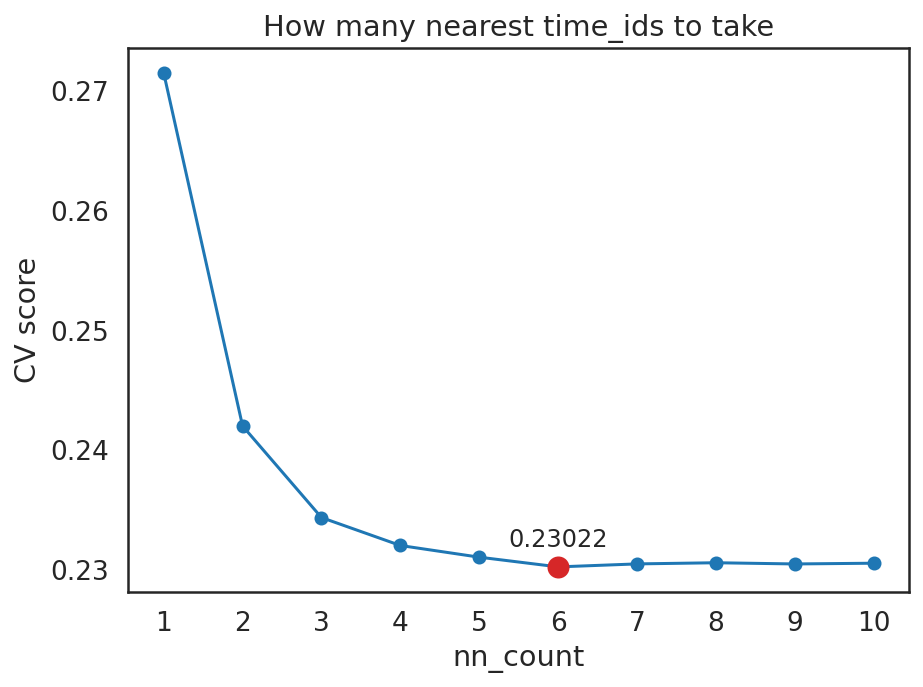

In [24]:
nn = NearestNeighbors(algorithm='brute')
nn.fit(df_prices_denorm_scaled)
nn_ind = nn.kneighbors(df_prices_denorm_scaled, n_neighbors=10, return_distance=False)

results = []
for nn_count in range(1, 11):
    time_ind = df_target_train.time_id.factorize()[0]
    stock_ind = df_target_train.stock_id.factorize()[0]
    df_train = df_rv_train.pivot('time_id', 'stock_id', 'rv')
    
    # a bit of advanced indexing to gather nearest rv
    df_train = pd.DataFrame(df_train.values[
            nn_ind[time_ind, :nn_count],
            stock_ind[:, None]], 
        index=df_target_train.index)
    df_train.rename(lambda x: f'rv_{x}', axis=1, inplace=True)
    df_train.fillna(df_train.mean(), inplace=True)

    model = LinearRegression()
    scores = cross_val_score(model, df_train, df_target_train.target, 
                             groups=df_target_train.time_id, 
                             scoring=make_scorer(rmspe),
                             fit_params={'sample_weight': 1 / df_target_train.target ** 2})
    
    results.append({'nn_count': nn_count, 'score': scores.mean()})
    
df_results = pd.DataFrame(results)
ax = df_results.plot(x='nn_count', y='score', style='-C0o', figsize=(7, 5), legend=False)
best = df_results.iloc[df_results.score.argmin()]
plt.plot(best.nn_count, best.score, 'C3o', markersize=10)
plt.annotate(f'{best.score:.5f}', xy=(best.nn_count, best.score), xytext=(0, 10), 
             fontsize=12, textcoords='offset points', ha='center')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
plt.ylabel('CV score')
plt.title('How many nearest time_ids to take');

In the plot above nn_count=1 effectively means we use only one feature - current realized volatility as input, and you can see that providing realized volatility from neighbour time_ids greatly improves the score from *0.27* to *0.23*, and it plateaus after nn_count > 6.

Finally let's train model using optimal nn_count=6 and use it for predicting on test.

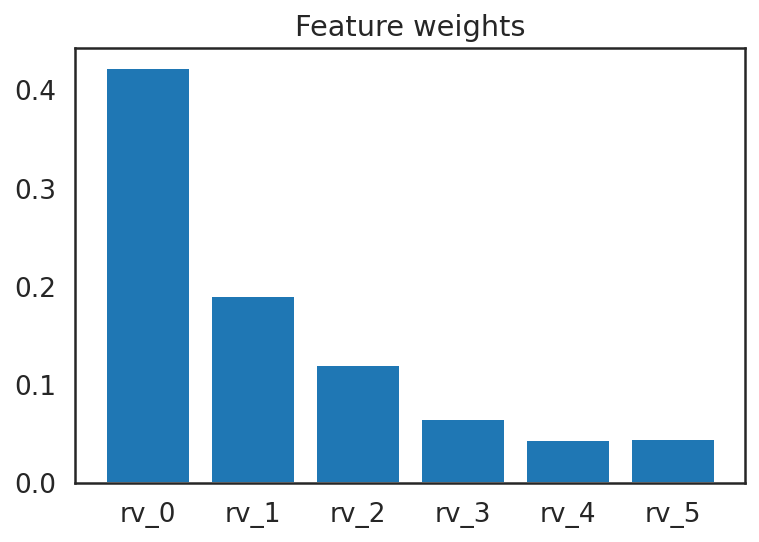

In [25]:
nn_count = 6

time_ind = df_target_train.time_id.factorize()[0]
stock_ind = df_target_train.stock_id.factorize()[0]
df_train = df_rv_train.pivot('time_id', 'stock_id', 'rv')

df_train = pd.DataFrame(df_train.values[
        nn_ind[time_ind, :nn_count],
        stock_ind[:, None]], 
    index=df_target_train.index)
df_train.rename(lambda x: f'rv_{x}', axis=1, inplace=True)
df_train.fillna(df_train.mean(), inplace=True)

model = LinearRegression()
model.fit(df_train, df_target_train.target, sample_weight=1 / df_target_train.target ** 2)

plt.bar(x=df_train.columns, height=model.coef_);
plt.title('Feature weights');

In [26]:
df_files = pd.DataFrame({'book_path': glob(f'{data_dir}/book_test.parquet/**/*.parquet')}) \
    .assign(stock_id=lambda x: x.book_path.str.extract("stock_id=(\d+)").astype('int')) \
    .sort_values('stock_id')

df_submission = pd.read_csv(f'{data_dir}/test.csv')

df_prices_denorm_test = pd.concat(Parallel(n_jobs=-1, verbose=0)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
df_prices_denorm_test = df_prices_denorm_test.pivot('time_id', 'stock_id', 'price')
df_prices_denorm_scaled_test = df_prices_denorm_test.fillna(df_prices_denorm_test.mean())
df_prices_denorm_scaled_test = pd.DataFrame(minmax_scale(df_prices_denorm_scaled_test), index=df_prices_denorm_test.index)

df_rv_test = pd.concat(Parallel(n_jobs=-1, verbose=0)(
        delayed(calc_rv)(r) for _, r in df_files.iterrows()))

if len(df_prices_denorm_scaled_test) == 1:
    nn_ind = np.zeros((3, nn_count), dtype='int')
else:
    nn = NearestNeighbors(algorithm='brute')
    nn.fit(df_prices_denorm_scaled_test)
    nn_ind = nn.kneighbors(df_prices_denorm_scaled_test, n_neighbors=10, return_distance=False)

time_ind = df_submission.time_id.factorize()[0]
stock_ind = df_submission.stock_id.factorize()[0]
df_test = df_rv_test.pivot('time_id', 'stock_id', 'rv')

df_test = pd.DataFrame(df_test.values[
        nn_ind[time_ind, :nn_count],
        stock_ind[:, None]], 
    index=df_submission.index)
df_test.rename(lambda x: f'rv_{x}', axis=1, inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

df_submission['target'] = model.predict(df_test)
df_submission = df_submission[['row_id', 'target']]
df_submission.to_csv('submission.csv', index=False)
df_submission.head()

row_id    target
0    0-4  0.000306
1   0-32  0.000306
2   0-34  0.000306

PLB of this submission was **0.21379**